# Project :  Predicting Used Car Prices in Virginia using Machine Learning

## 1. Exploring the Data
Let's start with importing the necessary libaries, reading in the data and checking out the dataset.

###  1.1  Libraries to load

In [1]:
import pandas as pd
import numpy as np
import re
import pymysql, pickle
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVR
from xgboost import XGBRegressor
import xgboost as xgb
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error, r2_score
from warnings import filterwarnings

filterwarnings("ignore", category=UserWarning)

### 1.2 Load data

The stored data retrieved through data crawling in AWS MySQL is loaded into a DataFrame

In [2]:
def load_data():

    # Read Password

    pw = pickle.load(open('./Flask/pickle/pw.pkl', 'rb'))
    host_ = pickle.load(open('./Flask/pickle/host.pkl', 'rb')) 
    
    # AWS MySql Connection Info
    db = pymysql.connect(
        host = host_,
        user = "root",
        password = pw,
        db = "usedcar",
        charset='utf8',
    )

    SQL_QUERY = """
        SELECT *
        FROM usedcar;
    """

    train = pd.read_sql(SQL_QUERY, db)
    pickle.dump(train, open("./Flask/pickle/database.pkl", "wb"))
    
    return train

In [3]:
train = load_data()

### 1.3 Check data

In [4]:
print(f'There are {train.shape[0]} rows and {train.shape[1]} columns') 

There are 46924 rows and 14 columns


#### Comments :
There are 46924 instances of data and its number of attributes equals 14

### 1.4 Check data type

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46924 entries, 0 to 46923
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              46924 non-null  object
 1   Year            46924 non-null  int64 
 2   Brand           46924 non-null  object
 3   Model           46924 non-null  object
 4   Mileage         46924 non-null  int64 
 5   Bodystyle       46545 non-null  object
 6   Exterior Color  46924 non-null  object
 7   Interior Color  46923 non-null  object
 8   Drivetrain      46924 non-null  object
 9   MPG             46924 non-null  object
 10  Fuel Type       46924 non-null  object
 11  Transmission    46924 non-null  object
 12  Engine          46924 non-null  object
 13  Price           46924 non-null  int64 
dtypes: int64(3), object(11)
memory usage: 5.0+ MB


#### Comments :

Out of a total of 14 columns, 3 are of type int64, while the remaining 11 are of type object. The total number of data entries is 46924, and it was observed that Bodystyle and Interior Color have some missing values.

### 1.5 Status of Train data

In [6]:
train.describe()

,Year,Mileage,Price
count,46924.000000,46924.000000,4.692400e+04
mean,2016.172769,62118.963707,4.035456e+04
std,7.413188,50519.289211,7.761011e+04
min,1937.000000,0.000000,2.432000e+03
25%,2014.000000,22556.000000,1.476800e+04
50%,2018.000000,50650.000000,2.500000e+04
75%,2021.000000,91468.000000,4.064900e+04
max,2024.000000,369197.000000,3.599000e+06


#### Comments :

There are no missing data in the numerical columns, and the oldest car was produced in 1937. The lowest price for a vehicle can be confirmed to be around $2,432.

## 2. Data Cleaning

### 2.1 Remove duplicate data using ID

The ID column is a combination of Year, Brand, Model, Mileage, and Dealer and was created to delete duplicate data. Now delete duplicate data using this column data

In [7]:
train = train.drop_duplicates(['ID']).reset_index(drop=True)
print(f'There are {train.shape[0]} rows and {train.shape[1]} columns') 

There are 4898 rows and 14 columns


#### Comments :

All duplicate data was deleted, leaving only 4898 out of 46924 data.
Since small data will affect performance when creating machine learning models later, I need to think about how to solve this problem.

### 2.2 Check the missing values

In [8]:
import missingno as msno 

<Axes: >

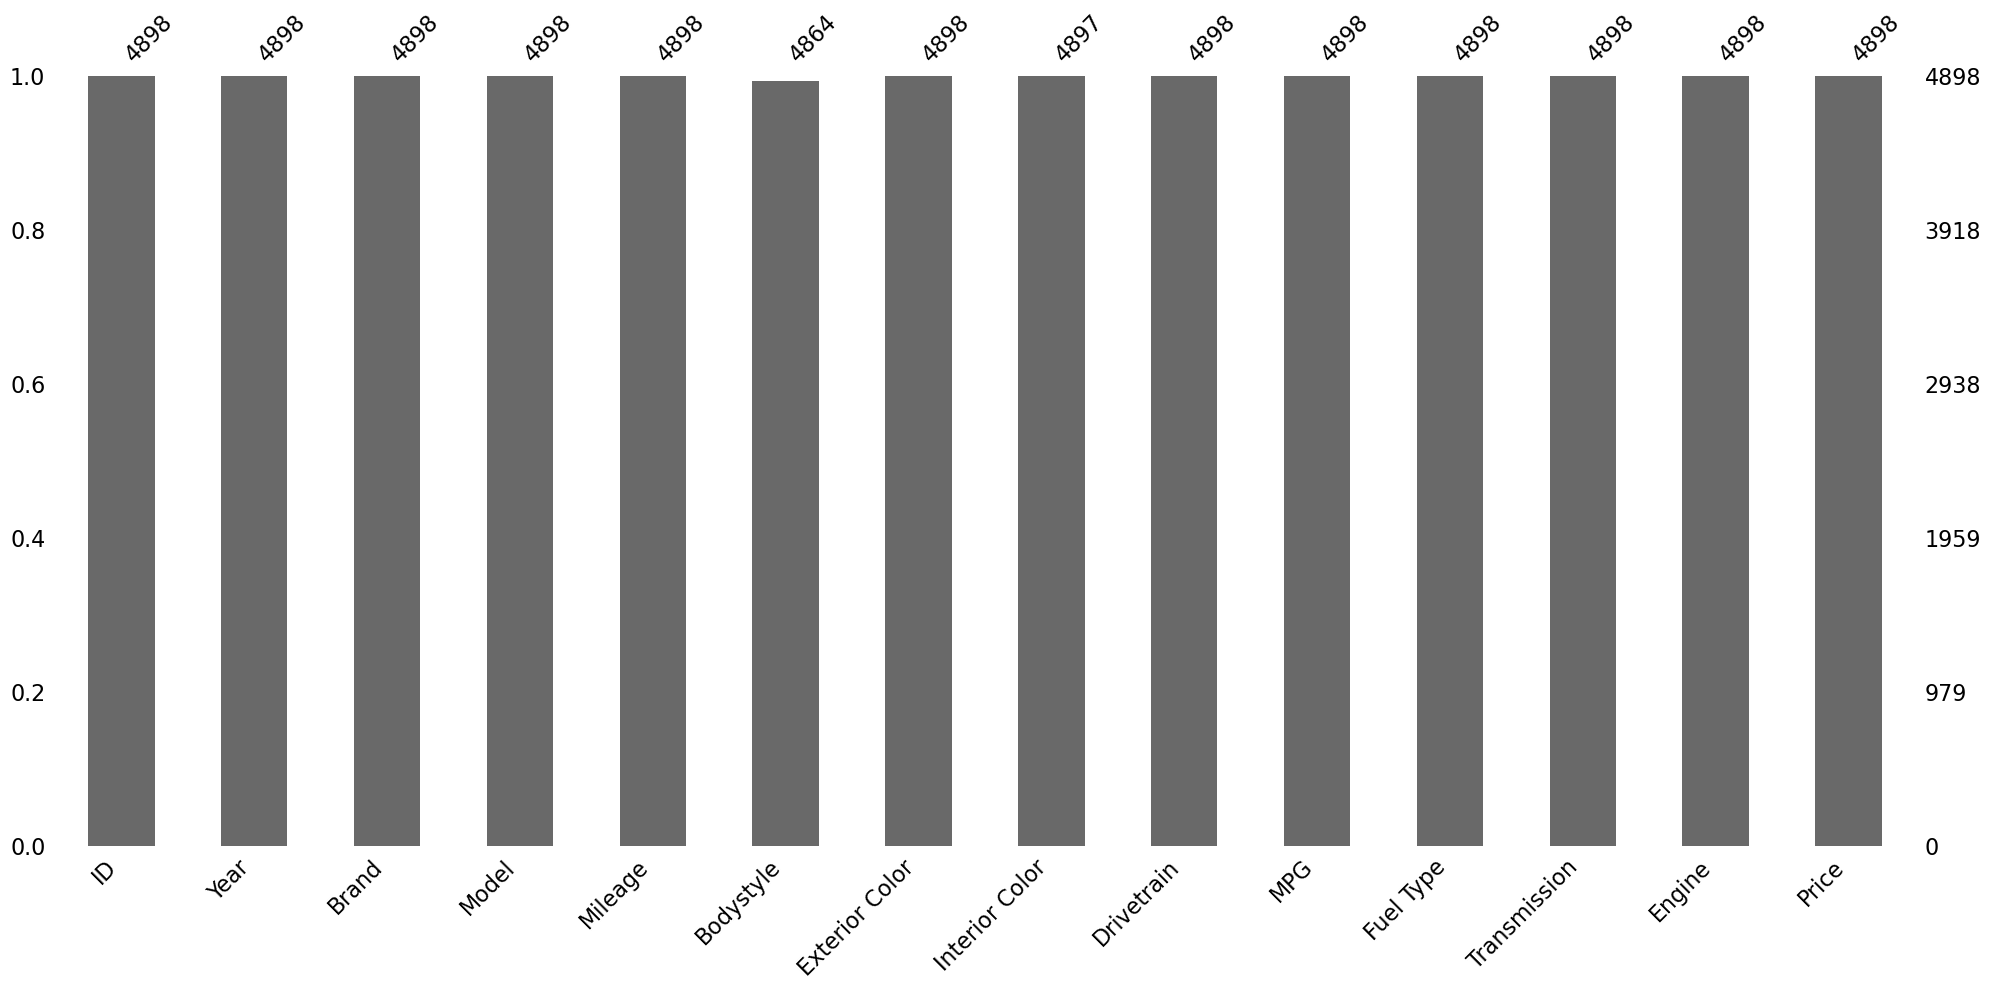

In [9]:
#Visualize missing values
msno.bar(train)

#### Comments :

It has been confirmed that there is missing data in Bodystyle and Interior Color, and it is necessary to add appropriate data.

### Adding the values at missing data

In [11]:
# Define a function to fill missing values with the most frequent value in each group
def fill_missing(group):
    mode_value = group.mode()
    if not mode_value.empty:
        return group.fillna(mode_value.iloc[0])
    else:
        return group

# Group by 'Model' column and apply the custom function to fill missing values in 'Bodystyle' column
train['Bodystyle'] = train.groupby('Model')['Bodystyle'].apply(fill_missing).reset_index(drop=True)

# Group by 'Model' column and apply the custom function to fill missing values in 'Interior Color' column
train['Interior Color'] = train.groupby('Model')['Interior Color'].apply(fill_missing).reset_index(drop=True)


<Axes: >

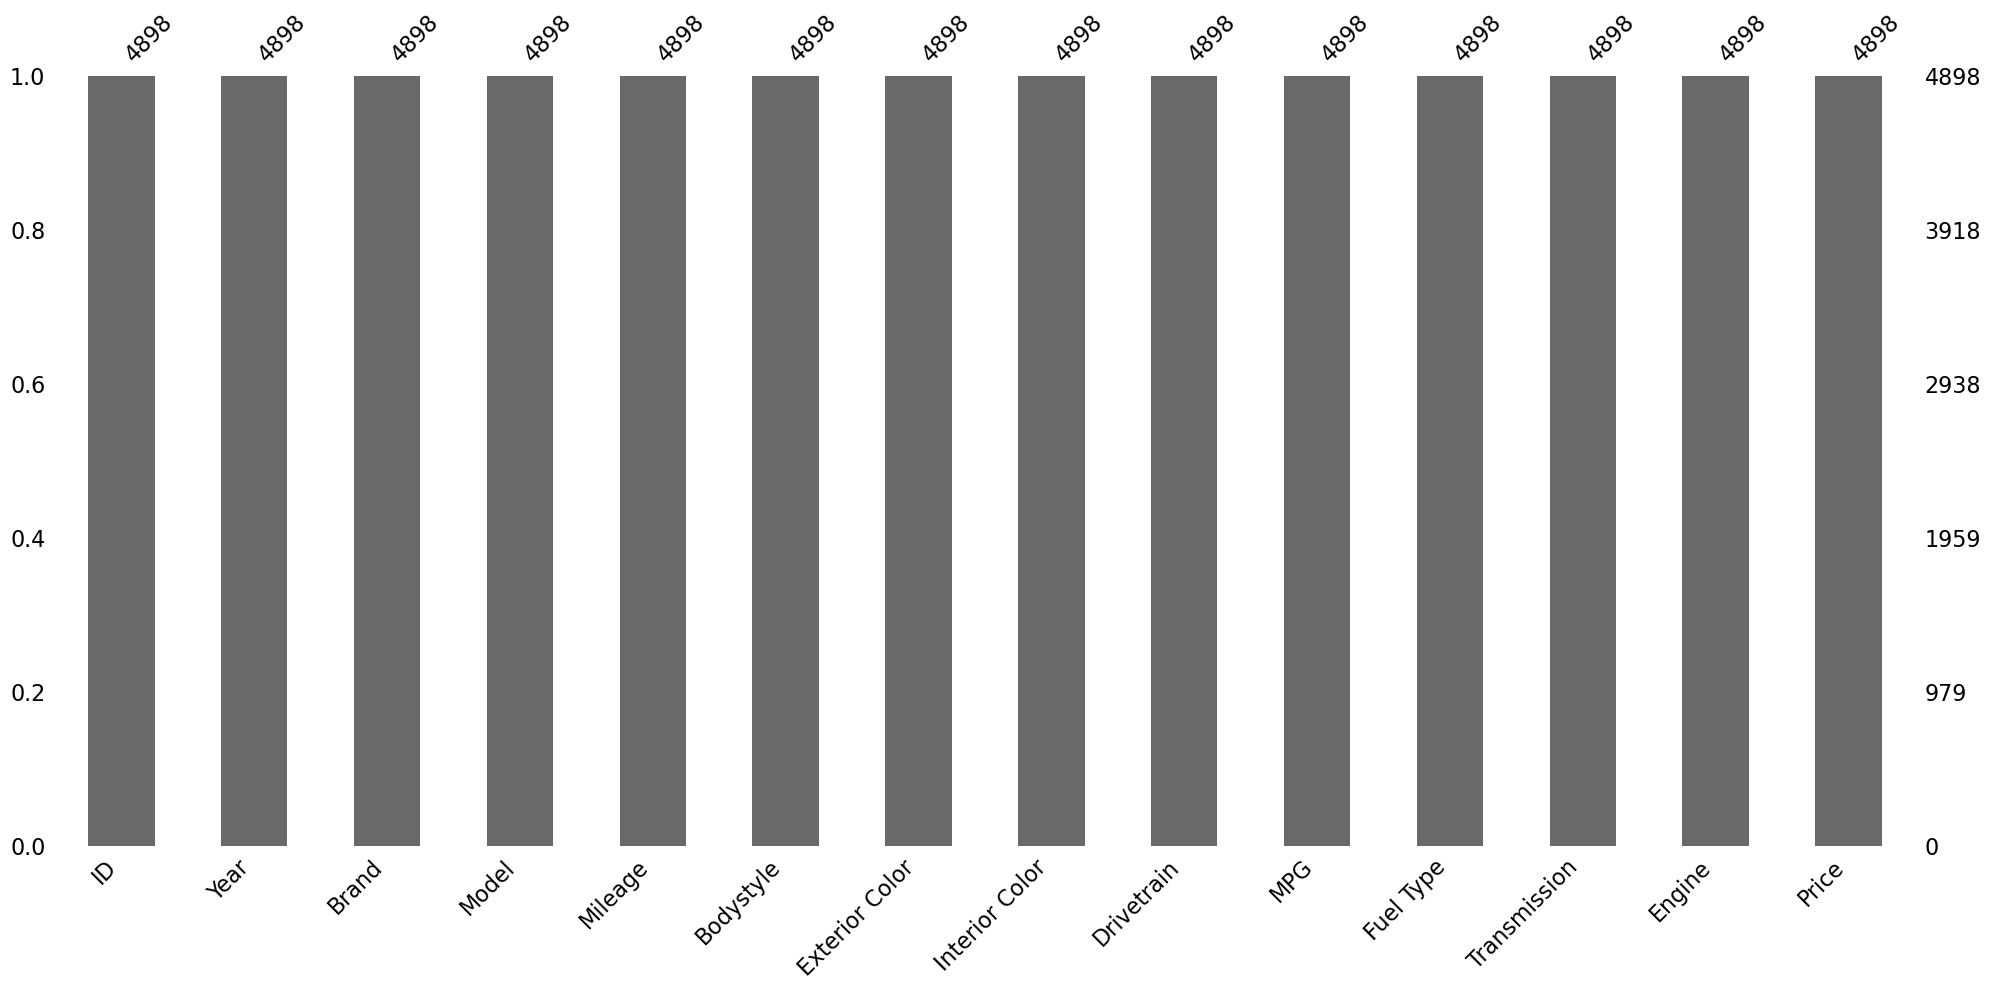

In [12]:
#Visualize missing values
msno.bar(train)

#### Comments :

There are no more missing values

### 2.3 Delete unnecessary columns

Need to remove the ID for deleting duplicate data during data analysis.

In [13]:
train = train.drop(columns=['ID']).reset_index(drop=True)

### 2.4 Find and remove the outliers

The outliers could compromise the predictive power of the model. Using the quartile method, outliers in the prices of used cars were identified and removed.

In [15]:
# Identifying outliers
Q1 = train['Price'].quantile(0.25)
Q3 = train['Price'].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

count_lower_bound = len(train[train['Price'] < lower_bound])
print("Lower Bound Price : ", lower_bound)
print("Number of cars priced below lower_bound :", count_lower_bound)
print("")


count_upper_bound = len(train[train['Price'] > upper_bound])
print("Upper Bound Price : ", upper_bound)
print("Number of cars priced above upper_bound :", count_upper_bound)
print("")

outliers = train[(train['Price'] < lower_bound) | (train['Price'] > upper_bound)]
outlier_prices = outliers['Price']
print("Number of outliers:", len(outlier_prices))


# Delete rows containing outliers.
train = train[~train['Price'].isin(outlier_prices)]

# Check the data after deletion.
print("Total number of rows after removing outliers:", len(train))

Lower Bound Price :  -20593.5
Number of cars priced below lower_bound : 0

Upper Bound Price :  76722.5
Number of cars priced above upper_bound : 419

Number of outliers: 419
Total number of rows after removing outliers: 4479


#### Comments :

The lower bound was -20,593.5, and the upper bound was 76,722.5, resulting in a total of 419 data points included within these values. These outlier data were subsequently removed from the dataset. So, the current remaining number of data is approximately 4,479.

## 3. Exploratory Data Analysis (EDA)

### 3.1 Examination of price trend

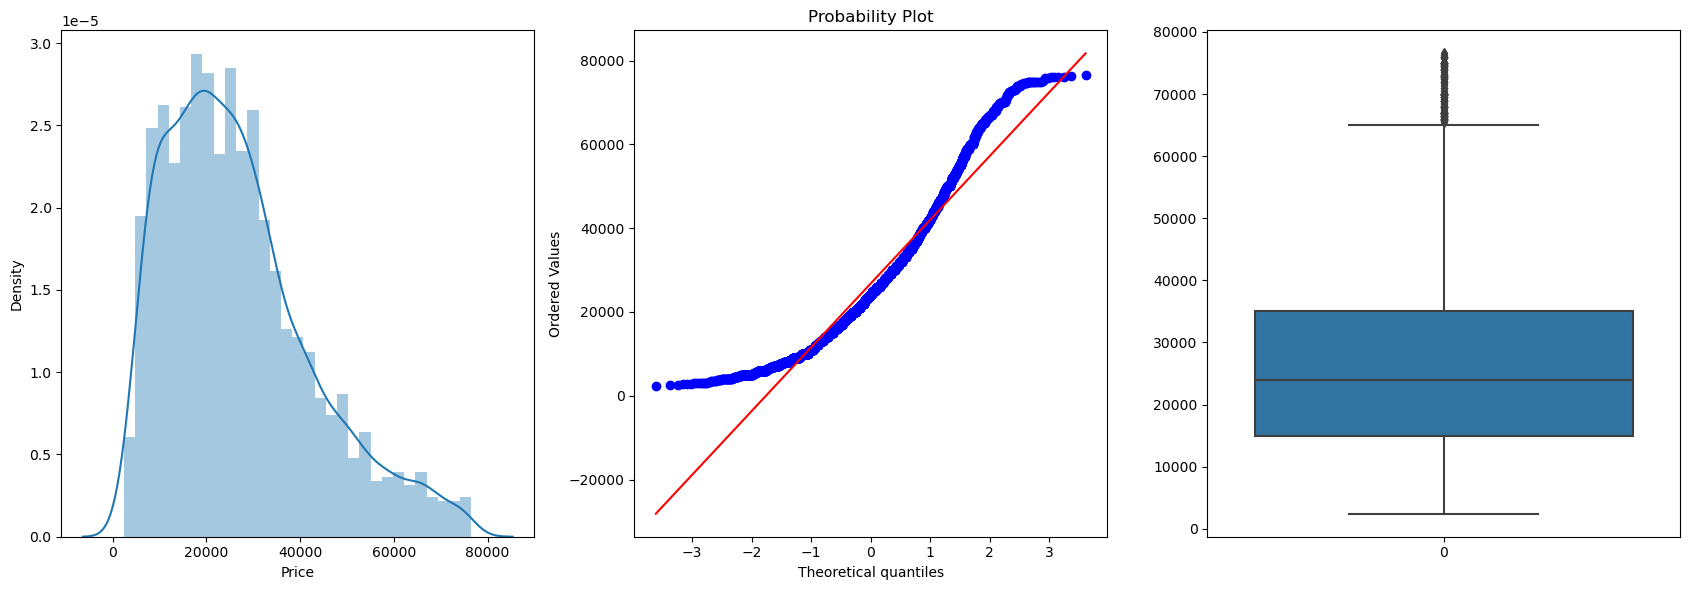

count     4479.000000
mean     26779.188212
std      15714.309215
min       2432.000000
25%      14950.000000
50%      23998.000000
75%      34995.000000
max      76557.000000
Name: Price, dtype: float64 

Skewness: 0.888484
Kurtosis: 0.377538


In [16]:
from scipy import stats
import seaborn as sns

plt.figure(figsize=(17,6))

plt.subplot(131)
sns.distplot(train["Price"])

plt.subplot(132)
stats.probplot(train["Price"], plot=plt)

plt.subplot(133)
sns.boxplot(train["Price"])
plt.tight_layout()
plt.show()

print(train["Price"].describe(),"\n")

print("Skewness: %f" % train['Price'].skew())
print("Kurtosis: %f" % train['Price'].kurt())

#### Comments :

It is apparent that used car price doesn't follow normal distribution and has positive skewness. The distribution of used car prices exhibits slight asymmetry, with a skewness of 0.88 and a kurtosis of 0.37. 

Most of the data is concentrated on the left side, forming a long tail on the right side. And its mean price is 26,779, with the lowest price being 2,432 and the highest price being 76,557

### 3.2 Normalized price

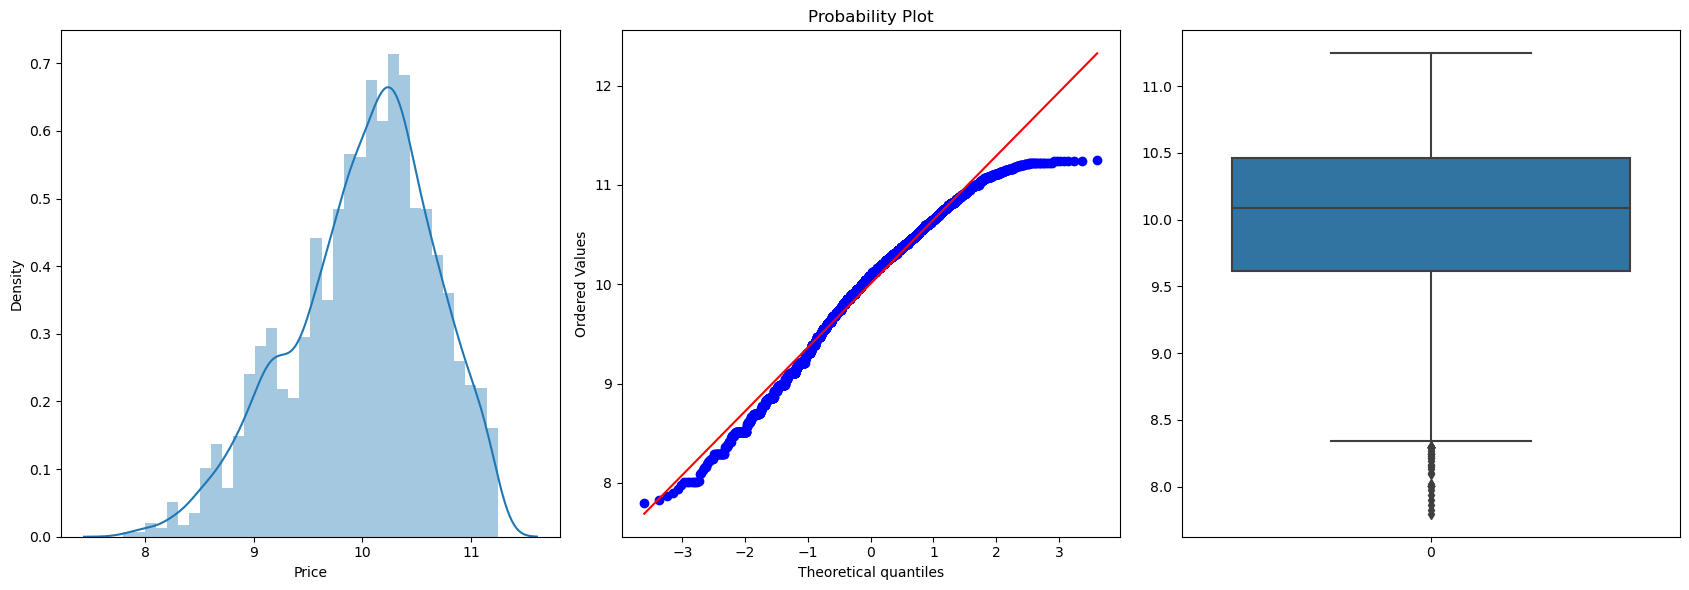

count    4479.000000
mean       10.007320
std         0.648500
min         7.796880
25%         9.612533
50%        10.085767
75%        10.462989
max        11.245804
Name: Price, dtype: float64 

Skewness: -0.484131
Kurtosis: -0.153538


In [17]:
nomalized_Price = np.log1p(train["Price"])

plt.figure(figsize=(17,6))

plt.subplot(131)
sns.distplot(nomalized_Price)

plt.subplot(132)
stats.probplot(nomalized_Price, plot=plt)

plt.subplot(133)
sns.boxplot(nomalized_Price)
plt.tight_layout()
plt.show()

print(nomalized_Price.describe(),"\n")

print("Skewness: %f" % nomalized_Price.skew())
print("Kurtosis: %f" % nomalized_Price.kurt())

#### Comments :

Applying the logarithm transforms the used car prices into a more normalized distribution. The reason for using natural logarithm transformation is to alleviate the skewness effect in the data. By taking the logarithm of the used car prices, it compresses the scale of the data, mitigates the influence of extreme values, and makes the distribution more symmetrical. The used car prices transformed in this way are used later when building the model.

### 3.3 Relationship between features and price
### 3.3.1 Year vs Price

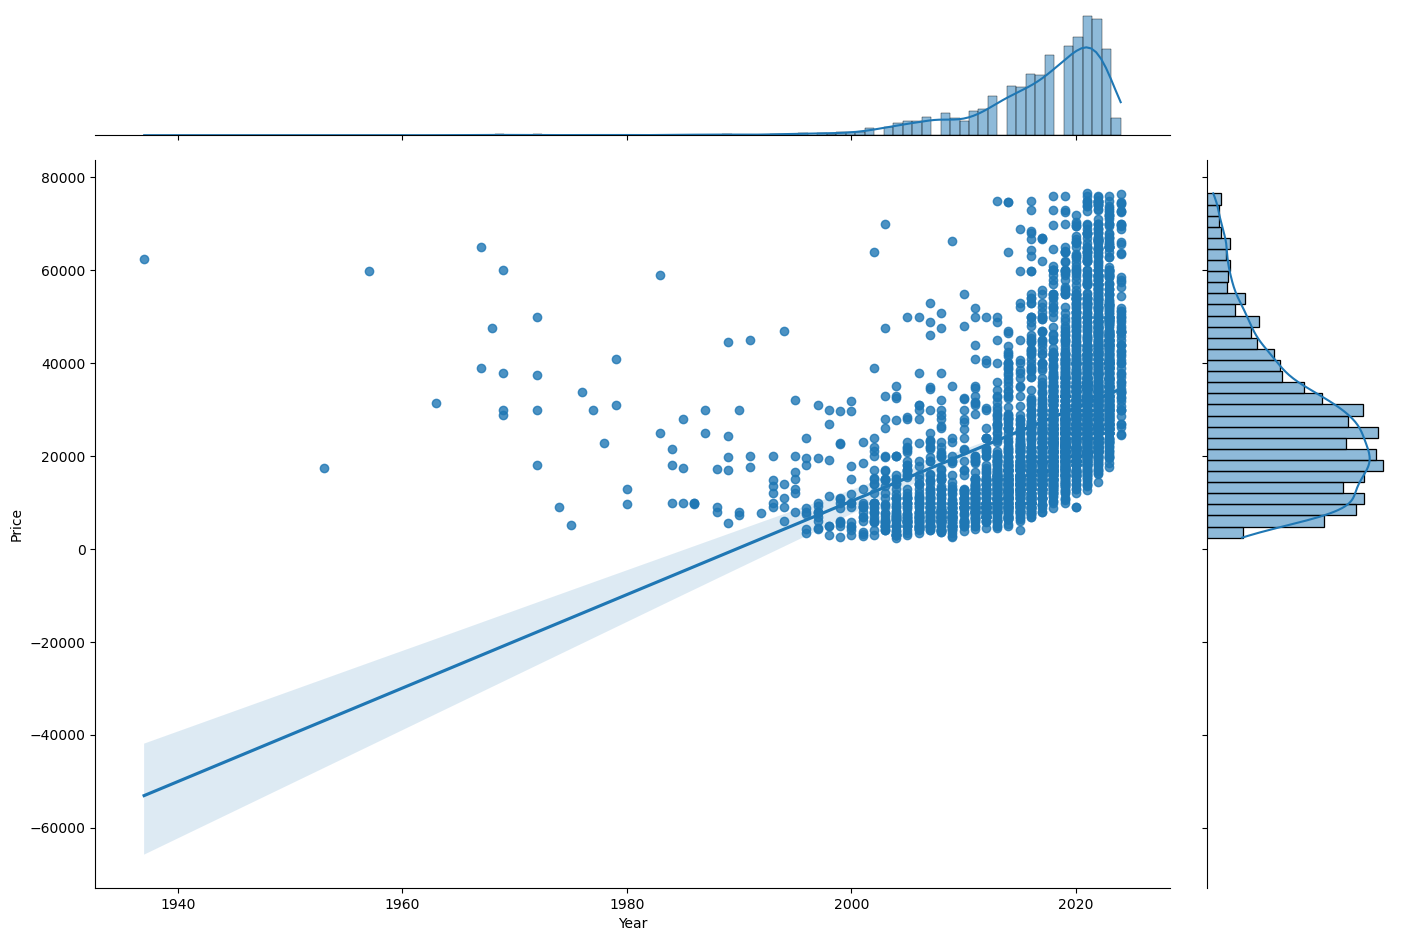

In [18]:
# Joint plot GrLivArea/saleprice
grid = sns.jointplot(x = "Year", y = "Price", data=train, kind="reg")
grid.fig.set_size_inches(15,10)

#### Comments :

It shows a positive correlation. The more recent the year, the prices tend to be higher.

In [19]:
filtered_data = train[(train['Year'] <= 1989) & (train['Price'] >= 50000)]
sorted_filtered_data = filtered_data.sort_values(by='Year', ascending=True).reset_index(drop=True)
sorted_filtered_data

,Year,Brand,Model,Mileage,Bodystyle,Exterior Color,Interior Color,Drivetrain,MPG,Fuel Type,Transmission,Engine,Price
0,1937,ford,coupe,12065,suv,orange/red,graystone,rear-wheel,0–0,gasoline,automatic,350ci v8,62500
1,1957,porsche,356,5473,passenger_van,ivory,black/alloy/black,rear-wheel,0,gasoline,4-speed manual,1.9l flat-4,59900
2,1967,chevrolet,chevelle,61658,sedan,blue,gray,–,–,–,–,–,64957
3,1969,mercedes_benz,280se,103824,suv,tan,–,rear-wheel,0–0,gasoline,3 speed automatic,i-6 cyl,59996
4,1983,jeep,cj,2609,sedan,black,black,–,0–0,–,th350 automatic,chevy 350 v8,59000


#### Comments :

After researching cars that maintain high prices despite their age, I found five vehicles. They were produced before the 1990s and cost more than 50,000. In particular, a 1937 Ford coupe topped the list with a price of 62,500 followed by the 1957 Porsche 356 model at 59,900. I deleted this data because it was not realistic for predicting actual prices

In [20]:
train = train.drop(filtered_data.index)
filtered_data = train[(train['Year'] <= 1989) & (train['Price'] >= 50000)]

### 3.3.2 Mileage vs Price

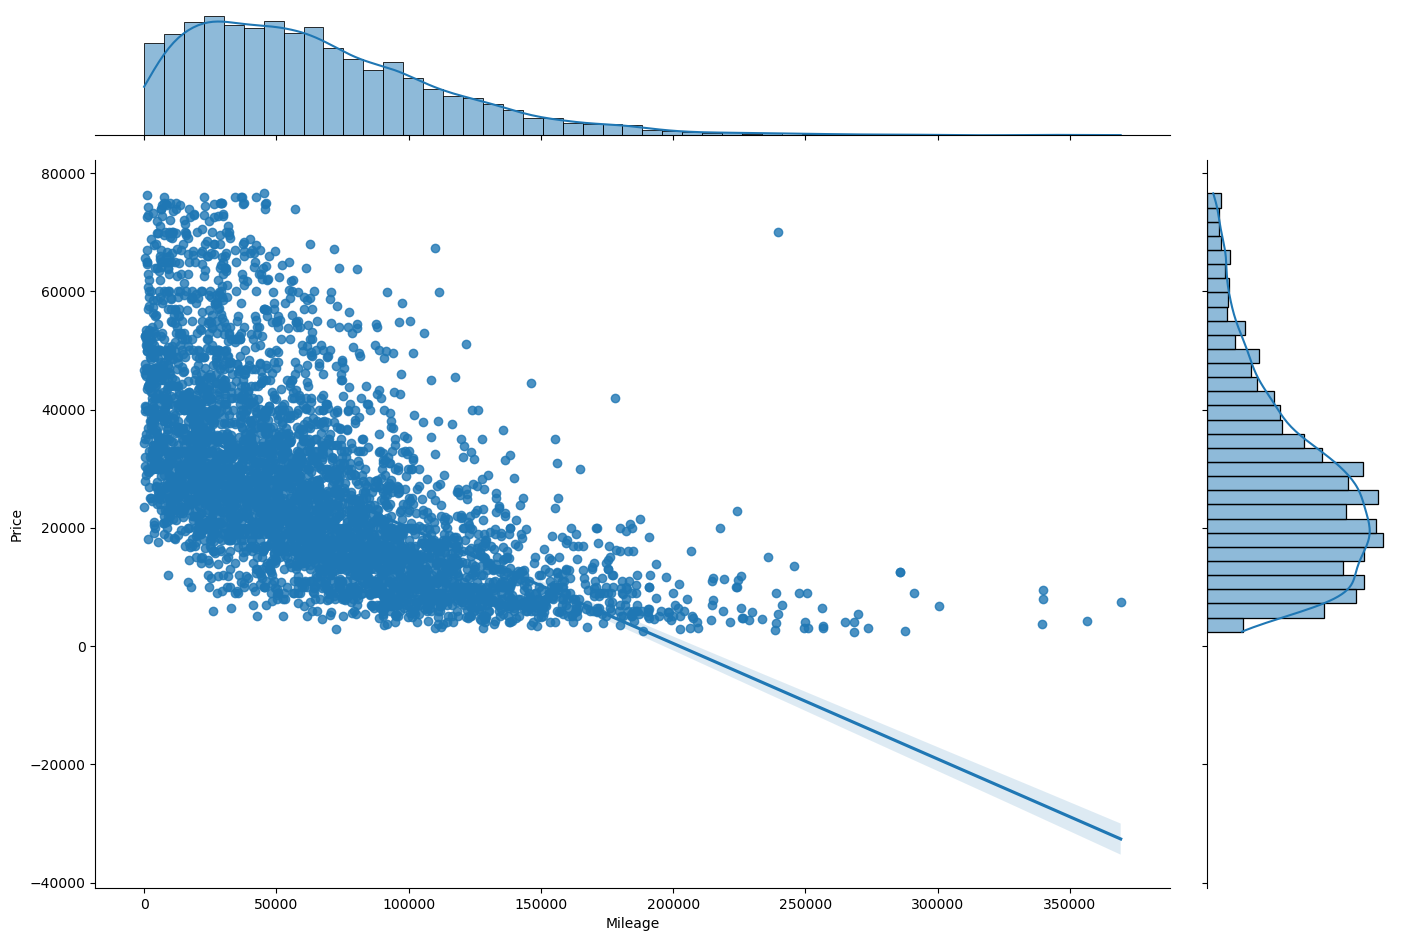

In [21]:
# Joint plot GrLivArea/saleprice
grid = sns.jointplot(x = "Mileage", y = "Price", data=train, kind="reg")
grid.fig.set_size_inches(15,10)

#### Comments :

Look into how used car prices vary depending on mileage. Found as expected generally the lower the mileage the higher the price.

In [22]:
filtered_data = train[(train['Mileage'] > 200000) & (train['Price'] >= 60000)]
sorted_filtered_data = filtered_data.sort_values(by='Mileage', ascending=True).reset_index(drop=True)
sorted_filtered_data

,Year,Brand,Model,Mileage,Bodystyle,Exterior Color,Interior Color,Drivetrain,MPG,Fuel Type,Transmission,Engine,Price
0,2003,ford,excursion,239470,suv,other,charcoal,four-wheel,–,diesel,5-speed automatic,6.0l v8 32v ddi ohv turbo diesel,69992


#### Comments :

There is a instance in the data where prices exceed 60,000 even with mileage exceeding 200,000. Upon reviewing the data, it was found that a Ford Excursion model from 2003, with mileage exceeding 230,000, had a price of 69,992. This data was removed from the train dataset as it was not realistic for predicting actual prices

In [23]:
train = train.drop(filtered_data.index)
filtered_data = train[(train['Mileage'] > 200000) & (train['Price'] >= 60000)]

### 3.3.3 Brand & Model vs Price

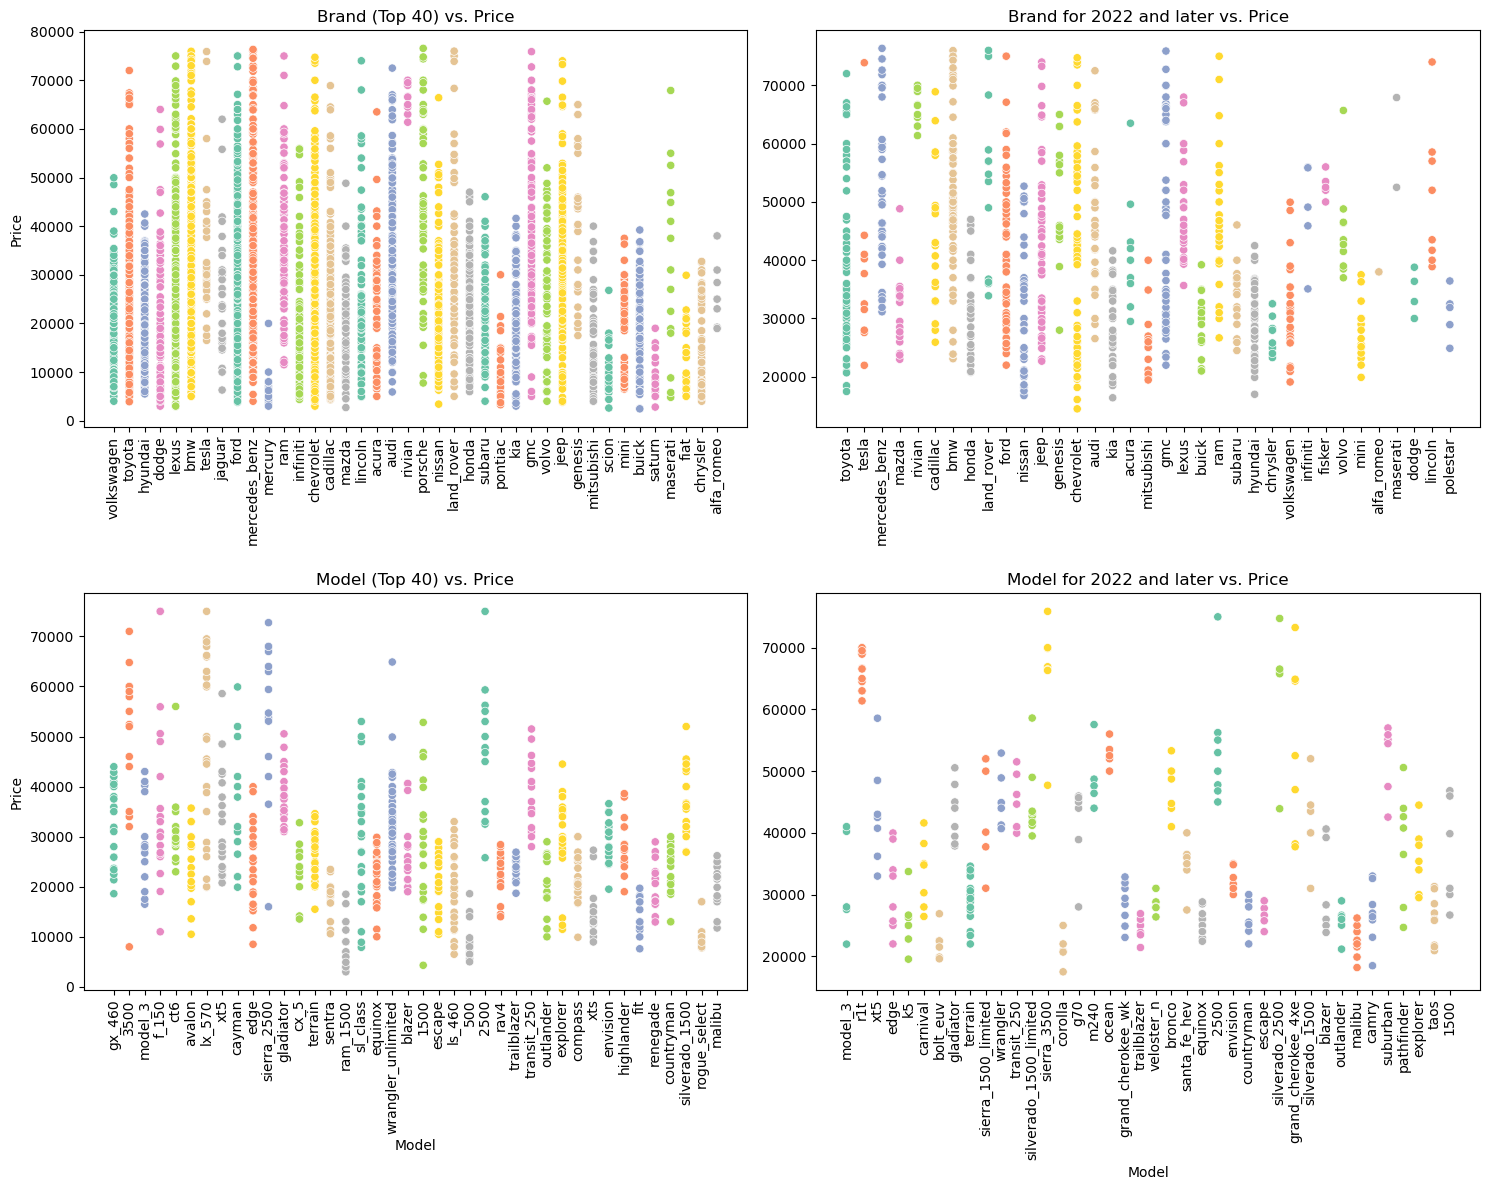

In [24]:
# Filter data for Year 2023 and later
train_2022 = train[train['Year'] >= 2022]

# Top 40 most frequent brands and models
top_brand = train['Brand'].value_counts().nlargest(40).index
top_model = train['Model'].value_counts().nlargest(40).index

# Top 40 most frequent brands and models for 2022 and later
top_brand_2022 = train_2022['Brand'].value_counts().nlargest(40).index
top_model_2022 = train_2022['Model'].value_counts().nlargest(40).index


# Extracting data corresponding to the top 40
top_brand_data = train[train['Brand'].isin(top_brand)]
top_model_data = train[train['Model'].isin(top_model)]

# Extract data corresponding to the top 40 brands and models for 2022 and later
top_brand_data_2022 = train_2022[train_2022['Brand'].isin(top_brand_2022)]
top_model_data_2022 = train_2022[train_2022['Model'].isin(top_model_2022)]


# Create a figure and axis objects
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))

# Scatterplot for Brand
sns.scatterplot(ax=axes[0, 0], x='Brand', y='Price', hue='Brand', data=top_brand_data, palette='Set2')
axes[0, 0].legend().remove()
axes[0, 0].set_title('Brand (Top 40) vs. Price')
axes[0, 0].set_xlabel('')
axes[0, 0].set_ylabel('Price')
axes[0, 0].tick_params(axis='x', rotation=90)


# Scatterplot for Brand for 2022 and later
sns.scatterplot(ax=axes[0, 1], x='Brand', y='Price', hue='Brand', data=top_brand_data_2022, palette='Set2')
axes[0, 1].legend().remove()
axes[0, 1].set_title('Brand for 2022 and later vs. Price')
axes[0, 1].set_xlabel('')
axes[0, 1].set_ylabel('')
axes[0, 1].tick_params(axis='x', rotation=90)


# Scatterplot for Model
sns.scatterplot(ax=axes[1, 0], x='Model', y='Price', hue='Model', data=top_model_data, palette='Set2')
axes[1, 0].legend().remove()
axes[1, 0].set_title('Model (Top 40) vs. Price')
axes[1, 0].set_xlabel('Model')
axes[1, 0].set_ylabel('Price')
axes[1, 0].tick_params(axis='x', rotation=90)


# Scatterplot for Model for 2022 and later
sns.scatterplot(ax=axes[1, 1], x='Model', y='Price', hue='Model', data=top_model_data_2022, palette='Set2')
axes[1, 1].legend().remove()
axes[1, 1].set_title('Model for 2022 and later vs. Price')
axes[1, 1].set_xlabel('Model')
axes[1, 1].set_ylabel('')
axes[1, 1].tick_params(axis='x', rotation=90)

plt.tight_layout(h_pad=2)
plt.show()




#### Comments :

In the price distribution by brand, Volkswagen, Hyundai, and Tesla were observed to be concentrated within the $50,000 range. Since older used cars tend to have lower prices, upon reevaluation using data from relatively newer cars produced after 2022, a similar distribution was observed. However, Toyota, Lexus, and Chevrolet had a broader distribution ranging from 10,000 to 70,000, and this distribution pattern remained consistent even for relatively newer cars produced after 2022. Regarding models, it was noted that prices were relatively concentrated within certain ranges for each model. Particularly, for cars produced after 2022, there was a more concentrated price distribution observed.

### 3.3.4 Exterior Color & Interior Color vs Price

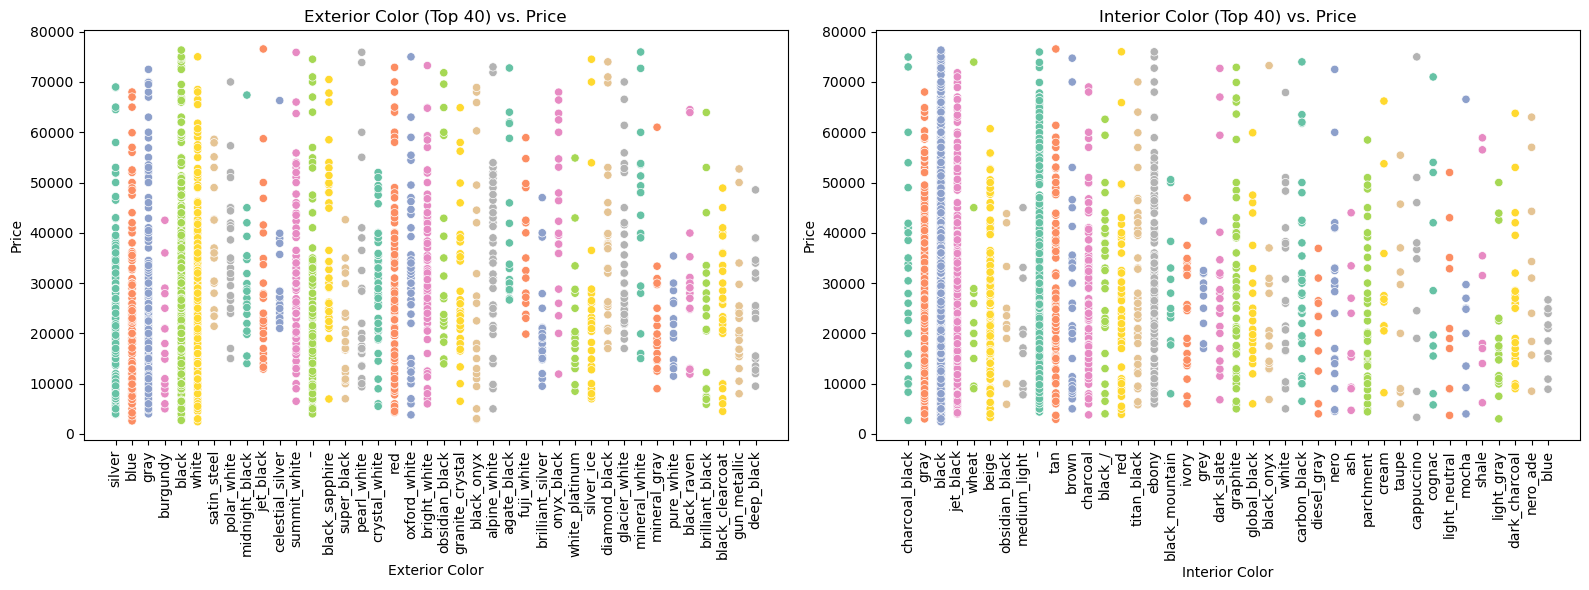

In [25]:
# Exterior Color and Interior Color preprocessing
train['Exterior Color'] = train['Exterior Color'].apply(lambda x: '_'.join(x.split()[:2]))
train['Interior Color'] = train['Interior Color'].apply(lambda x: '_'.join(x.split()[:2]) if isinstance(x, str) else x)

# top 40 most frequent  Colors
top_exterior_colors = train['Exterior Color'].value_counts().nlargest(40).index
top_interior_colors = train['Interior Color'].value_counts().nlargest(40).index

# Extracting data corresponding to the top 40
top_exterior_colors_data = train[train['Exterior Color'].isin(top_exterior_colors)]
top_interior_colors_data = train[train['Interior Color'].isin(top_interior_colors)]

# Create a figure and axis objects
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Scatterplot for Exterior Color
sns.scatterplot(ax=axes[0], x='Exterior Color', y='Price', hue='Exterior Color', data=top_exterior_colors_data, palette='Set2')
axes[0].legend().remove()
axes[0].set_title('Exterior Color (Top 40) vs. Price')
axes[0].set_xlabel('Exterior Color')
axes[0].set_ylabel('Price')
axes[0].tick_params(axis='x', rotation=90)

# Scatterplot for Interior Color
sns.scatterplot(ax=axes[1], x='Interior Color', y='Price', hue='Interior Color', data=top_interior_colors_data, palette='Set2')
axes[1].legend().remove()
axes[1].set_title('Interior Color (Top 40) vs. Price')
axes[1].set_xlabel('Interior Color')
axes[1].set_ylabel('Price')
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


#### Comments :

Colors like silver, blue, and gray in Exterior color were widely distributed from under 10,000 to as high as 70,000, while mineral_gray was concentrated below 35,000. Similarly, in Interior color, black was distributed across all price ranges. Consequently, it was observed that the exterior and interior colors seem to have little correlation with the price.

### 3.3.5 Drivetrain vs Price

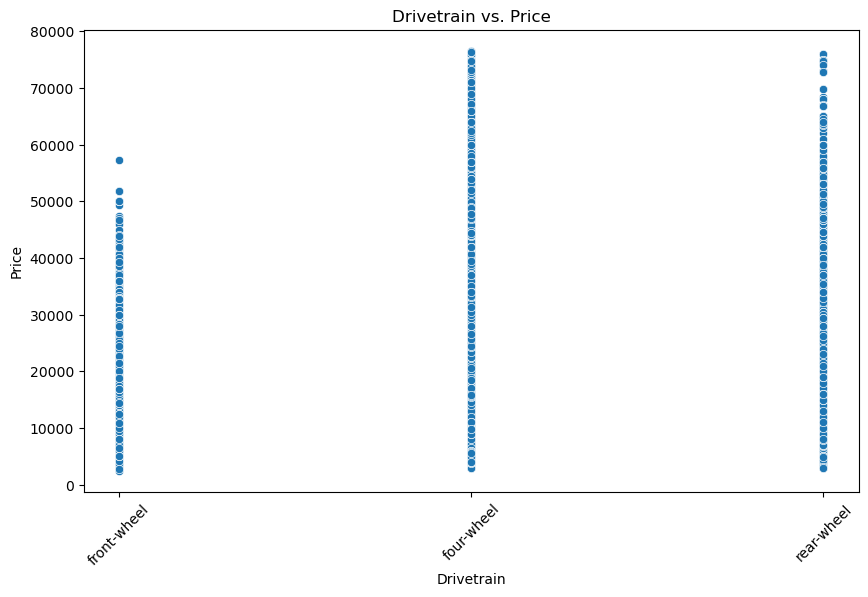

In [26]:
# Preprocessing
train['Drivetrain'] = train['Drivetrain'].replace({'fwd': 'front-wheel', 'rwd': 'rear-wheel', '4wd': 'four-wheel', 'all-wheel': 'four-wheel', 'awd': 'four-wheel','unknown': 'front-wheel','–': 'front-wheel'})

plt.figure(figsize=(10, 6)) 
sns.scatterplot(x='Drivetrain', y='Price', data=train)
plt.title('Drivetrain vs. Price')
plt.xlabel('Drivetrain')
plt.ylabel('Price')
plt.xticks(rotation=45) 
plt.show()

#### Comments :

The relationship between Drivetrain and price was as seen in Figure 11 below, where all three types of Drivetrain were evenly distributed across all prices. However, it was noted that there are no instances of front-wheel drive systems priced over 60,000, leading to the speculation that front-wheel drive systems tend to have lower prices compared to other drivetrain systems.

### 3.3.6 MPG, Fuel Type, Transmission Engine vs Price

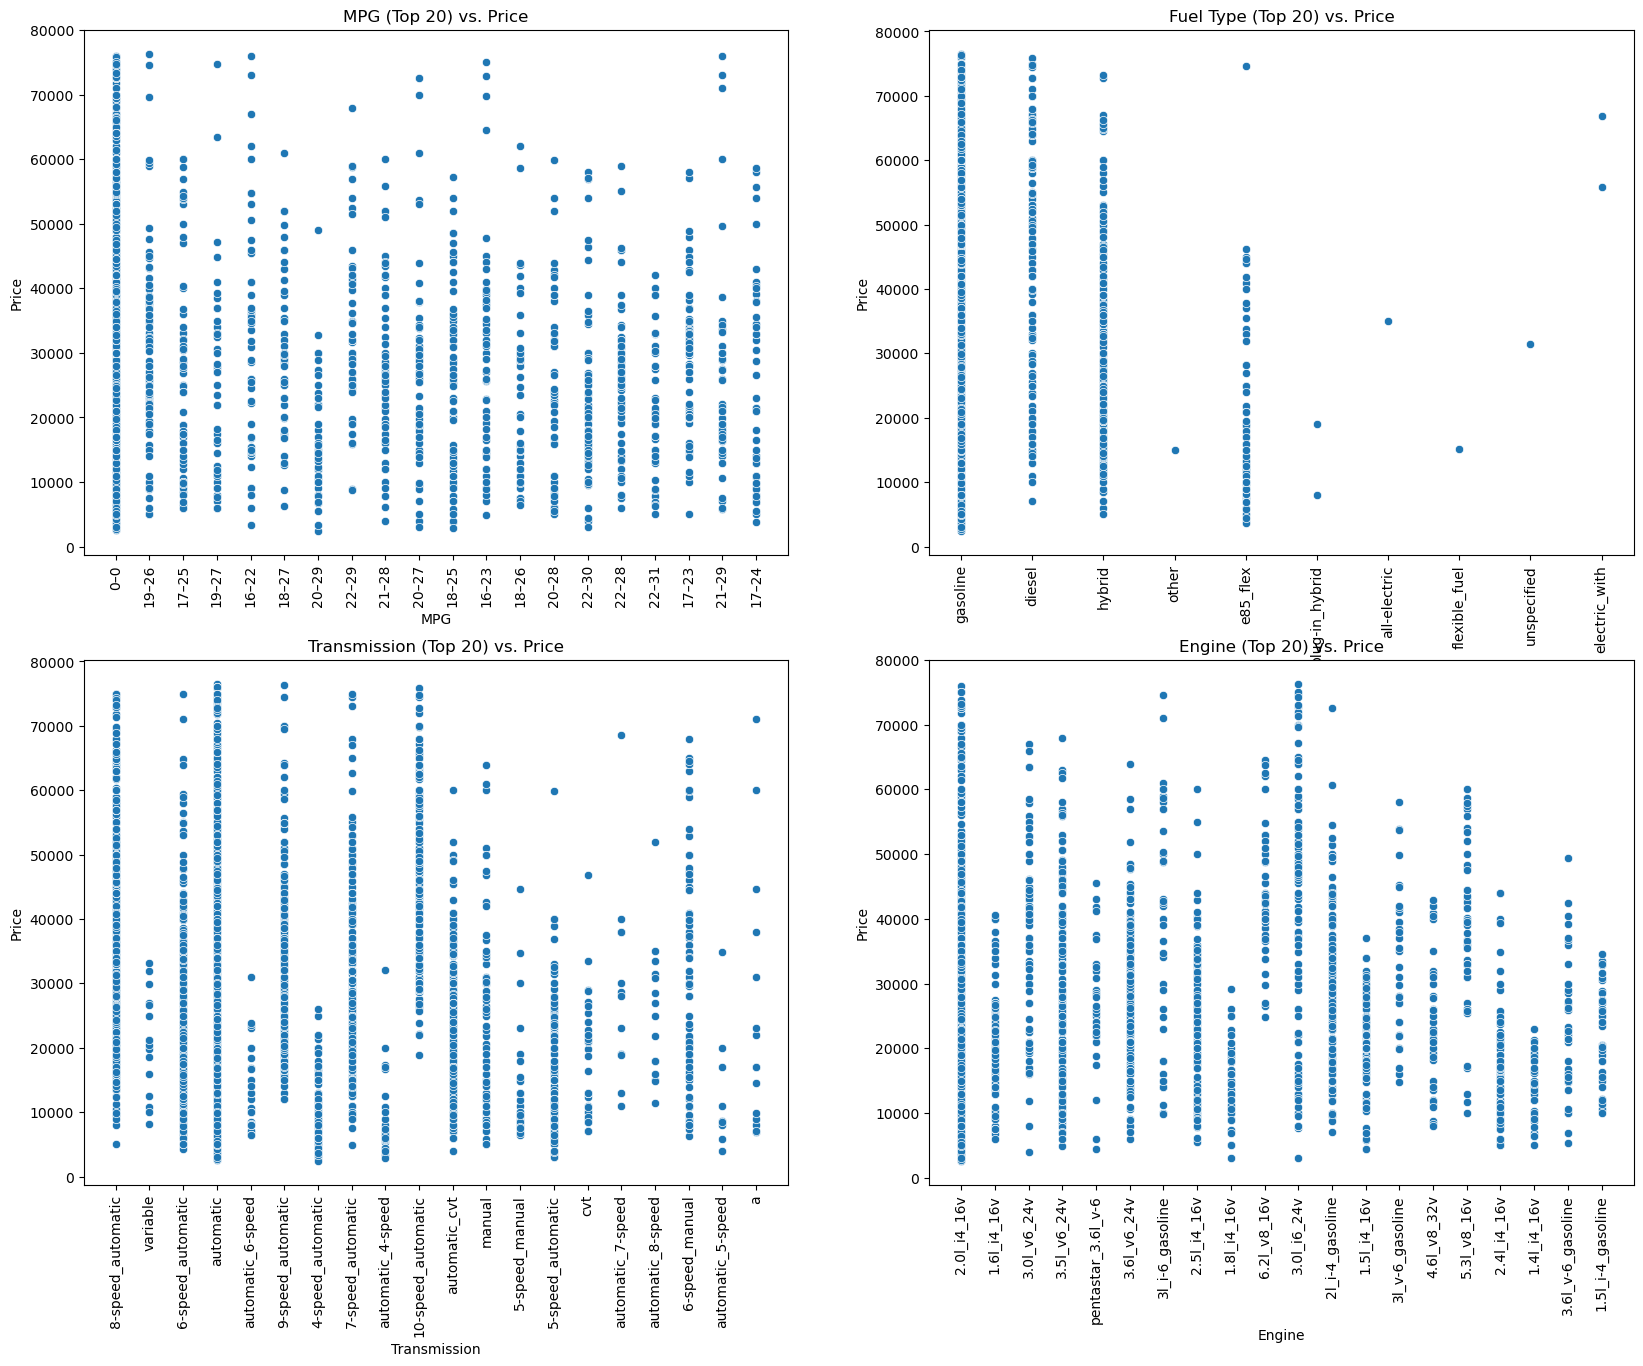

In [27]:
# Process the values of the 'MPG', 'Fuel Type', 'Transmission', 'Engine' columns and save them back to the train data
train['MPG'] = train['MPG'].apply(lambda x: '_'.join(x.split()[:2]))
train['Fuel Type'] = train['Fuel Type'].apply(lambda x: '_'.join(x.split()[:2]))
train['Transmission'] = train['Transmission'].apply(lambda x: '_'.join(x.split()[:2]))
train['Engine'] = train['Engine'].apply(lambda x: '_'.join(x.split()[:3]))

# Replace missing values or '-' with the most frequently used value in each column
train['MPG'].replace('', np.nan, inplace=True)
train['MPG'].replace('–', np.nan, inplace=True)
train['Fuel Type'].replace('', np.nan, inplace=True)
train['Fuel Type'].replace('–', np.nan, inplace=True)
train['Transmission'].replace('', np.nan, inplace=True)
train['Transmission'].replace('–', np.nan, inplace=True)
train['Engine'].replace('', np.nan, inplace=True)
train['Engine'].replace('–', np.nan, inplace=True)

train['MPG'].fillna(train['MPG'].mode()[0], inplace=True)
train['Fuel Type'].fillna(train['Fuel Type'].mode()[0], inplace=True)
train['Transmission'].fillna(train['Transmission'].mode()[0], inplace=True)
train['Engine'].fillna(train['Engine'].mode()[0], inplace=True)

# Extract the top 30 data for each column
top_mpg = train['MPG'].value_counts().nlargest(20).index
top_fuel_type = train['Fuel Type'].value_counts().nlargest(20).index
top_transmission = train['Transmission'].value_counts().nlargest(20).index
top_engine = train['Engine'].value_counts().nlargest(20).index

# Draw 4 scatterplot graphs
plt.figure(figsize=(20, 15))

plt.subplot(2, 2, 1)
sns.scatterplot(x='MPG', y='Price', data=train[train['MPG'].isin(top_mpg)])
plt.title('MPG (Top 20) vs. Price')
plt.xticks(rotation=90)

plt.subplot(2, 2, 2)
sns.scatterplot(x='Fuel Type', y='Price', data=train[train['Fuel Type'].isin(top_fuel_type)])
plt.title('Fuel Type (Top 20) vs. Price')
plt.xticks(rotation=90)

plt.subplot(2, 2, 3)
sns.scatterplot(x='Transmission', y='Price', data=train[train['Transmission'].isin(top_transmission)])
plt.title('Transmission (Top 20) vs. Price')
plt.xticks(rotation=90)

plt.subplot(2, 2, 4)
sns.scatterplot(x='Engine', y='Price', data=train[train['Engine'].isin(top_engine)])
plt.title('Engine (Top 20) vs. Price')
plt.xticks(rotation=90)

plt.show()


#### Comments :

The relationship between the remaining columns, MPG, Fuel Type, Transmission, Engine, and Price indicated that some values were widely distributed from below 10,000 to over 70,000. However, upon closer examination, many values were found to somewhat form price groups. In the case of Transmission, it could be observed that certain price ranges were partially formed based on the type of Transmission. Values such as variable, automatic 6-speed, and 4-speed automatic were concentrated in lower price ranges below 35,000. Additionally, concerning Fuel Type, the e85_flex value was distributed at slightly lower prices compared to other Fuel Types, and when there was a value of electric in Fuel Type, it was noted that prices tended to be over 30,000

In [28]:
train = train.reset_index(drop=True)
temp=train.copy()

## 4. Feature Engineering

### 4.1 Label Encoding for categorical variables

In [29]:
# Differentiating between numerical and categorical variables after checking the data type of each column
numerical_features = []
categorical_features = []
for f in train.columns:
    if train.dtypes[f] != 'object':
        numerical_features.append(f)
    else:
        categorical_features.append(f)

In [30]:
print("Numerical Features Qty :", len(numerical_features),"\n")
print("Numerical Features : ", numerical_features, "\n\n")
print("Categorical Features Qty :", len(categorical_features),"\n")
print("Categorical Features :", categorical_features)

Numerical Features Qty : 3 

Numerical Features :  ['Year', 'Mileage', 'Price'] 


Categorical Features Qty : 10 

Categorical Features : ['Brand', 'Model', 'Bodystyle', 'Exterior Color', 'Interior Color', 'Drivetrain', 'MPG', 'Fuel Type', 'Transmission', 'Engine']


In [31]:
# Creating a LabelEncoder object
label_encoder = LabelEncoder()

# Applying LabelEncoder to categorical variables and creating dummy variables
for feature in categorical_features:
    train[feature] = label_encoder.fit_transform(train[feature])
train.head()

,Year,Brand,Model,Mileage,Bodystyle,Exterior Color,Interior Color,Drivetrain,MPG,Fuel Type,Transmission,Engine,Price
0,2021,51,788,23626,11,617,133,1,171,5,40,70,23998
1,2023,50,605,2947,10,732,163,1,362,5,97,166,33217
2,2017,19,87,97675,11,186,248,1,220,5,21,34,9497
3,2016,11,252,107671,11,106,49,1,206,5,21,70,6941
4,2021,27,414,61418,11,562,278,0,43,5,56,324,37999


### 4.2 Calculate correlation with Price

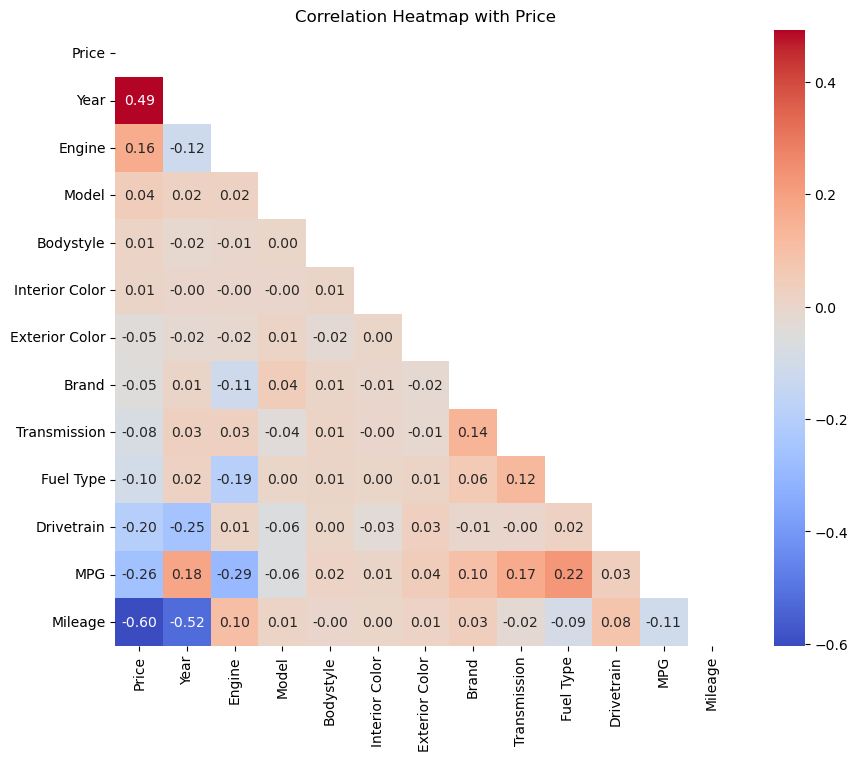

In [32]:
# Calculate correlation in dataframe including Price variable
corr_with_price = train.corr()['Price'].sort_values(ascending=False)

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(train[corr_with_price.index].corr(), dtype=bool))

# Draw heatmap showing only the lower half
plt.figure(figsize=(10, 8))
sns.heatmap(train[corr_with_price.index].corr(), annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
plt.title('Correlation Heatmap with Price')
plt.show()

#### Comments :

 'Year' showed a correlation of 0.49 with the price, while 'Mileage' showed a correlation of -0.60. It was observed that as 'Year' increases, the price tends to rise, whereas as 'Mileage' increases, the price tends to decrease. Additionally, correlations of 0.1 or higher were found among Engine, Fuel Type, Drivetrain, and MPG. Surprisingly, it was discovered that Brand and Model had low correlations with price.

### 4.3 Comparison between Normalized vs Non-normalized

The existing numerical variables, year, mileage, and price, were normalized to reduce differences in scale and magnitude between variables. To verify whether this normalization actually helps machine learning performance, normalized and non-normalized data were input into two machine learning models and compared R-squared values

In [33]:
# Creating dummy variables
normalize_num = np.log1p(train[numerical_features])
X_train_0 = normalize_num.join(train[categorical_features])

# Normarized data
y_train_normalized = X_train_0["Price"]
X_train_normalized = X_train_0.drop("Price", axis=1)
X_train_normalized.head()

,Year,Mileage,Brand,Model,Bodystyle,Exterior Color,Interior Color,Drivetrain,MPG,Fuel Type,Transmission,Engine
0,7.611842,10.070145,51,788,11,617,133,1,171,5,40,70
1,7.612831,7.988882,50,605,10,732,163,1,362,5,97,166
2,7.609862,11.489411,19,87,11,186,248,1,220,5,21,34
3,7.609367,11.586845,11,252,11,106,49,1,206,5,21,70
4,7.611842,11.025475,27,414,11,562,278,0,43,5,56,324


In [34]:
# Non Normarized data
train_not_normalized = train
y_train_not = train_not_normalized["Price"]
X_train_not = train_not_normalized.drop("Price", axis=1)
X_train_not.head()

,Year,Brand,Model,Mileage,Bodystyle,Exterior Color,Interior Color,Drivetrain,MPG,Fuel Type,Transmission,Engine
0,2021,51,788,23626,11,617,133,1,171,5,40,70
1,2023,50,605,2947,10,732,163,1,362,5,97,166
2,2017,19,87,97675,11,186,248,1,220,5,21,34
3,2016,11,252,107671,11,106,49,1,206,5,21,70
4,2021,27,414,61418,11,562,278,0,43,5,56,324


### 4.3.1 Model : RandomForestRegressor 

In [36]:
# Initialize K-ford
k_fold_10 = KFold(n_splits=10, shuffle=True, random_state=2024)

# Convert X_train1 and y_train1 to NumPy arrays if they are not already
X_train = np.array(X_train_normalized)
y_train = np.array(y_train_normalized)

X_train_not = np.array(X_train_not)
y_train_not = np.array(y_train_not)

# Initialize the model
model = RandomForestRegressor(random_state=2024)
model_not = RandomForestRegressor(random_state=2024)

# Evaluate model performance through cross-validation with normalized features
r2_scores_1 = []   
for train_index, val_index in k_fold_10.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    model.fit(X_train_fold, y_train_fold)
    y_pred = model.predict(X_val_fold)
    
    # Calculate R-squared
    r2 = r2_score(y_val_fold, y_pred)  
    r2_scores_1.append(r2)


# Evaluate model performance through cross-validation with Non normalized features
r2_scores_2 = []    
for train_index, val_index in k_fold_10.split(X_train_not, y_train_not):
    X_train_fold, X_val_fold = X_train_not[train_index], X_train_not[val_index]
    y_train_fold, y_val_fold = y_train_not[train_index], y_train_not[val_index]
    
    model_not.fit(X_train_fold, y_train_fold)
    y_pred = model_not.predict(X_val_fold)

    # Calculate R-squared
    r2 = r2_score(y_val_fold, y_pred)  
    r2_scores_2.append(r2)
    

# Calculate average R-squared through cross-validation
avg_r2_1 = np.mean(r2_scores_1)
avg_r2_2 = np.mean(r2_scores_2)
print("R-squared for model with normalized features: {:.2f}".format(avg_r2_1))
print("R-squared for model with non-normalized features: {:.2f}".format(avg_r2_2))

R-squared for model with normalized features: 0.83
R-squared for model with non-normalized features: 0.81


### 4.3.2 Model : XGBoost

In [37]:
# Initialize K-ford
k_fold_10 = KFold(n_splits=10, shuffle=True, random_state=2024)

# Convert X_train1 and y_train1 to NumPy arrays if they are not already
X_train = np.array(X_train_normalized)
y_train = np.array(y_train_normalized)

X_train_not = np.array(X_train_not)
y_train_not = np.array(y_train_not)

# Initialize the model
model = xgb.XGBRegressor(random_state=2024)
model_not = xgb.XGBRegressor(random_state=2024)

# Evaluate model performance through cross-validation with normalized features
r2_scores_1 = []   
for train_index, val_index in k_fold_10.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    model.fit(X_train_fold, y_train_fold)
    y_pred = model.predict(X_val_fold)
    
    # Calculate R-squared
    r2 = r2_score(y_val_fold, y_pred)  
    r2_scores_1.append(r2)


# Evaluate model performance through cross-validation with Non normalized features
r2_scores_2 = []    
for train_index, val_index in k_fold_10.split(X_train_not, y_train_not):
    X_train_fold, X_val_fold = X_train_not[train_index], X_train_not[val_index]
    y_train_fold, y_val_fold = y_train_not[train_index], y_train_not[val_index]
    
    model_not.fit(X_train_fold, y_train_fold)
    y_pred = model_not.predict(X_val_fold)

    # Calculate R-squared
    r2 = r2_score(y_val_fold, y_pred)  
    r2_scores_2.append(r2)
    

# Calculate average R-squared through cross-validation
avg_r2_1 = np.mean(r2_scores_1)
avg_r2_2 = np.mean(r2_scores_2)
print("R-squared for model with normalized features: {:.2f}".format(avg_r2_1))
print("R-squared for model with non-normalized features: {:.2f}".format(avg_r2_2))

R-squared for model with normalized features: 0.87
R-squared for model with non-normalized features: 0.85


#### Comments :

Observed that both machine learning models had higher R-squared values when the numerical variables were normalized compared to when they were not. This indicated that normalization contributes to improving the performance of machine learning models. As a result, normalized data was used for training all machine learning models

### 4.4 Variance Inflation Factor (VIF)

VIF(Variance Inflation Factor) is a metric used to assess multicollinearity in regression analysis. Multicollinearity occurs when independent variables have high correlations with each other. In such cases, the accuracy of estimated regression coefficients in regression analysis decreases, leading to inaccurate predictions or interpretations. 

In [38]:
# Add constant term
X = add_constant(X_train_normalized)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [round(variance_inflation_factor(X.values, i), 2) for i in range(X.shape[1])]

# Split DataFrame into two columns
half = len(vif_data) // 2
vif_data_first_half = vif_data.iloc[:half].reset_index(drop=True)
vif_data_second_half = vif_data.iloc[half:].reset_index(drop=True)

# Merge the two DataFrames side by side
vif_data_final = pd.concat([vif_data_first_half, vif_data_second_half], axis=1)

vif_data_final


,feature,VIF,feature,VIF
0,const,7207043.56,Exterior Color,1.00
1,Year,1.43,Interior Color,1.00
2,Mileage,1.31,Drivetrain,1.08
3,Brand,1.04,MPG,1.22
4,Model,1.01,Fuel Type,1.09
5,Bodystyle,1.00,Transmission,1.07
6,NaN,NaN,Engine,1.15


#### Comments :

it was found that all VIF values were below 2, indicating low multicollinearity and minimal correlation between the independent variables. The low VIF values indicated a low likelihood of multicollinearity and minimal correlation between independent variables. Therefore, it seemed appropriate to use all features from the perspective of VIF.

## 5. Data Splitting for training and testing

Given the limited amount of available data, it was deemed appropriate to maximize the performance of machine learning using this used car data by training models through cross-validation using either K-Fold or ShuffleSplit. Therefore, these two cross-validation methods were used to split the data into 5 and 10 subsets, respectively, and trained these 2 models. Then, the comparison was made to determine which method yielded better model performance using R-squared values and RMSE.

### 5.1 Comparison : KFold VS ShuffleSplit
### 5.1.1 Model : RandomForestRegressor 

In [39]:
# Fix random seed for reproducibility
np.random.seed(2024)

# Initialize K-ford
k_fold_5 = KFold(n_splits=5, shuffle=True, random_state=2024)
k_fold_10 = KFold(n_splits=10, shuffle=True, random_state=2024)

# Initialize ShuffleSplit
shuffle_split_5 = ShuffleSplit(n_splits=5, test_size=0.25, random_state=2024)
shuffle_split_10 = ShuffleSplit(n_splits=10, test_size=0.25, random_state=2024)

# Convert to NumPy arrays 
X_train_array = np.array(X_train_normalized)
y_train_array = np.array(y_train_normalized)

# Initialize the model
model_1 = RandomForestRegressor(random_state=2024)
model_2 = RandomForestRegressor(random_state=2024)
model_3 = RandomForestRegressor(random_state=2024)
model_4 = RandomForestRegressor(random_state=2024)

# Evaluate model performance through cross-validation
r2_scores_1 = []    
rmse_scores_1 = [] 
for train_index, val_index in k_fold_5.split(X_train_array, y_train_array):
    X_train_fold, X_val_fold = X_train_array[train_index], X_train_array[val_index]
    y_train_fold, y_val_fold = y_train_array[train_index], y_train_array[val_index]
    
    model_1.fit(X_train_fold, y_train_fold)
    y_pred = model_1.predict(X_val_fold)
    
    # Calculate R-squared
    r2 = r2_score(y_val_fold, y_pred)  
    r2_scores_1.append(r2)
    
    # Revert the logged price back to its original price
    y_pred = np.expm1(y_pred)
    y_val_fold = np.expm1(y_val_fold)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))  
    rmse_scores_1.append(rmse)

# Evaluate model performance through cross-validation
r2_scores_1 = []    
rmse_scores_1 = [] 
for train_index, val_index in k_fold_5.split(X_train_array, y_train_array):
    X_train_fold, X_val_fold = X_train_array[train_index], X_train_array[val_index]
    y_train_fold, y_val_fold = y_train_array[train_index], y_train_array[val_index]
    
    model_1.fit(X_train_fold, y_train_fold)
    y_pred = model_1.predict(X_val_fold)
    
    # Calculate R-squared
    r2 = r2_score(y_val_fold, y_pred)  
    r2_scores_1.append(r2)
    
    # Revert the logged price back to its original price
    y_pred = np.expm1(y_pred)
    y_val_fold = np.expm1(y_val_fold)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))  
    rmse_scores_1.append(rmse)
    
# Evaluate model performance through cross-validation
r2_scores_2 = []   
rmse_scores_2 = [] 
for train_index, val_index in k_fold_10.split(X_train_array, y_train_array):
    X_train_fold, X_val_fold = X_train_array[train_index], X_train_array[val_index]
    y_train_fold, y_val_fold = y_train_array[train_index], y_train_array[val_index]
    
    model_2.fit(X_train_fold, y_train_fold)
    y_pred = model_2.predict(X_val_fold)

    # Calculate R-squared
    r2 = r2_score(y_val_fold, y_pred) 
    r2_scores_2.append(r2)

    # Revert the logged price back to its original price
    y_pred = np.expm1(y_pred)
    y_val_fold = np.expm1(y_val_fold)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))  
    rmse_scores_2.append(rmse)

# Evaluate model performance through cross-validation
r2_scores_3 = []   
rmse_scores_3 = [] 
for train_index, val_index in shuffle_split_5.split(X_train_array, y_train_array):
    X_train_fold, X_val_fold = X_train_array[train_index], X_train_array[val_index]
    y_train_fold, y_val_fold = y_train_array[train_index], y_train_array[val_index]
    
    model_3.fit(X_train_fold, y_train_fold)
    y_pred = model_3.predict(X_val_fold)

    # Calculate R-squared
    r2 = r2_score(y_val_fold, y_pred)  
    r2_scores_3.append(r2)
    
    # Revert the logged price back to its original price
    y_pred = np.expm1(y_pred)
    y_val_fold = np.expm1(y_val_fold)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))  
    rmse_scores_3.append(rmse)

# Evaluate model performance through cross-validation
r2_scores_4 = []   
rmse_scores_4 = [] 
for train_index, val_index in shuffle_split_10.split(X_train_array, y_train_array):
    X_train_fold, X_val_fold = X_train_array[train_index], X_train_array[val_index]
    y_train_fold, y_val_fold = y_train_array[train_index], y_train_array[val_index]
    
    model_4.fit(X_train_fold, y_train_fold)
    y_pred = model_4.predict(X_val_fold)
    
    # Calculate R-squared
    r2 = r2_score(y_val_fold, y_pred)  
    r2_scores_4.append(r2) 
    
    # Revert the logged price back to its original price
    y_pred = np.expm1(y_pred)
    y_val_fold = np.expm1(y_val_fold)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))  
    rmse_scores_4.append(rmse)

# Calculate average R-squared through cross-validation
avg_r2_1 = np.mean(r2_scores_1)
avg_r2_2 = np.mean(r2_scores_2)
avg_r2_3 = np.mean(r2_scores_3)
avg_r2_4 = np.mean(r2_scores_4)
print("R-squared for KFold 5 : {:.2f}".format(avg_r2_1))
print("R-squared for KFold 10 : {:.2f}".format(avg_r2_2))
print("R-squared for shuffle_split 5 : {:.2f}".format(avg_r2_3))
print("R-squared for shuffle_split 10 : {:.2f}".format(avg_r2_4))

# Calculate average RMSE through cross-validation
avg_rmse_1 = np.mean(rmse_scores_1)
avg_rmse_2 = np.mean(rmse_scores_2)
avg_rmse_3 = np.mean(rmse_scores_3)
avg_rmse_4 = np.mean(rmse_scores_4)
print("RMSE for KFold 5 : {:.2f}".format(avg_rmse_1))
print("RMSE for KFold 10 : {:.2f}".format(avg_rmse_2))
print("RMSE for shuffle_split 5 : {:.2f}".format(avg_rmse_3))
print("RMSE for shuffle_split 10 : {:.2f}".format(avg_rmse_4))

R-squared for KFold 5 : 0.83
R-squared for KFold 10 : 0.83
R-squared for shuffle_split 5 : 0.82
R-squared for shuffle_split 10 : 0.83
RMSE for KFold 5 : 7105.59
RMSE for KFold 10 : 7044.05
RMSE for shuffle_split 5 : 7252.24
RMSE for shuffle_split 10 : 7223.92


### 5.1.2 Model : XGBoost

In [40]:
# Fix random seed for reproducibility
np.random.seed(2024)

# Initialize the model
model_1 = xgb.XGBRegressor(random_state=2024)
model_2 = xgb.XGBRegressor(random_state=2024)
model_3 = xgb.XGBRegressor(random_state=2024)
model_4 = xgb.XGBRegressor(random_state=2024)

# Evaluate model performance through cross-validation
r2_scores_1 = []    
rmse_scores_1 = [] 
for train_index, val_index in k_fold_5.split(X_train_array, y_train_array):
    X_train_fold, X_val_fold = X_train_array[train_index], X_train_array[val_index]
    y_train_fold, y_val_fold = y_train_array[train_index], y_train_array[val_index]
    
    model_1.fit(X_train_fold, y_train_fold)
    y_pred = model_1.predict(X_val_fold)
    
    # Calculate R-squared
    r2 = r2_score(y_val_fold, y_pred)  
    r2_scores_1.append(r2)
    
    # Revert the logged price back to its original price
    y_pred = np.expm1(y_pred)
    y_val_fold = np.expm1(y_val_fold)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))  
    rmse_scores_1.append(rmse)
    

# Evaluate model performance through cross-validation
r2_scores_2 = []   
rmse_scores_2 = [] 
for train_index, val_index in k_fold_10.split(X_train_array, y_train_array):
    X_train_fold, X_val_fold = X_train_array[train_index], X_train_array[val_index]
    y_train_fold, y_val_fold = y_train_array[train_index], y_train_array[val_index]
    
    model_2.fit(X_train_fold, y_train_fold)
    y_pred = model_2.predict(X_val_fold)

    # Calculate R-squared
    r2 = r2_score(y_val_fold, y_pred) 
    r2_scores_2.append(r2)

    # Revert the logged price back to its original price
    y_pred = np.expm1(y_pred)
    y_val_fold = np.expm1(y_val_fold)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))  
    rmse_scores_2.append(rmse)


# Evaluate model performance through cross-validation
r2_scores_3 = []   
rmse_scores_3 = [] 
for train_index, val_index in shuffle_split_5.split(X_train_array, y_train_array):
    X_train_fold, X_val_fold = X_train_array[train_index], X_train_array[val_index]
    y_train_fold, y_val_fold = y_train_array[train_index], y_train_array[val_index]
    
    model_3.fit(X_train_fold, y_train_fold)
    y_pred = model_3.predict(X_val_fold)

    # Calculate R-squared
    r2 = r2_score(y_val_fold, y_pred)  
    r2_scores_3.append(r2)
    
    # Revert the logged price back to its original price
    y_pred = np.expm1(y_pred)
    y_val_fold = np.expm1(y_val_fold)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))  
    rmse_scores_3.append(rmse)

    
# Evaluate model performance through cross-validation
r2_scores_4 = []   
rmse_scores_4 = [] 
for train_index, val_index in shuffle_split_10.split(X_train_array, y_train_array):
    X_train_fold, X_val_fold = X_train_array[train_index], X_train_array[val_index]
    y_train_fold, y_val_fold = y_train_array[train_index], y_train_array[val_index]
    
    model_4.fit(X_train_fold, y_train_fold)
    y_pred = model_4.predict(X_val_fold)
    
    # Calculate R-squared
    r2 = r2_score(y_val_fold, y_pred)  
    r2_scores_4.append(r2) 
    
    # Revert the logged price back to its original price
    y_pred = np.expm1(y_pred)
    y_val_fold = np.expm1(y_val_fold)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))  
    rmse_scores_4.append(rmse)

    
# Calculate average R-squared through cross-validation
avg_r2_1 = np.mean(r2_scores_1)
avg_r2_2 = np.mean(r2_scores_2)
avg_r2_3 = np.mean(r2_scores_3)
avg_r2_4 = np.mean(r2_scores_4)
print("R-squared for KFold 5 : {:.2f}".format(avg_r2_1))
print("R-squared for KFold 10 : {:.2f}".format(avg_r2_2))
print("R-squared for shuffle_split 5 : {:.2f}".format(avg_r2_3))
print("R-squared for shuffle_split 10 : {:.2f}".format(avg_r2_4))


# Calculate average RMSE through cross-validation
avg_rmse_1 = np.mean(rmse_scores_1)
avg_rmse_2 = np.mean(rmse_scores_2)
avg_rmse_3 = np.mean(rmse_scores_3)
avg_rmse_4 = np.mean(rmse_scores_4)
print("RMSE for KFold 5 : {:.2f}".format(avg_rmse_1))
print("RMSE for KFold 10 : {:.2f}".format(avg_rmse_2))
print("RMSE for shuffle_split 5 : {:.2f}".format(avg_rmse_3))
print("RMSE for shuffle_split 10 : {:.2f}".format(avg_rmse_4))

R-squared for KFold 5 : 0.87
R-squared for KFold 10 : 0.87
R-squared for shuffle_split 5 : 0.86
R-squared for shuffle_split 10 : 0.86
RMSE for KFold 5 : 6109.92
RMSE for KFold 10 : 5943.31
RMSE for shuffle_split 5 : 6266.68
RMSE for shuffle_split 10 : 6245.90


#### Comments :

It was found that the model's performance improved when the data was split into 10 subsets instead of 5, and it was observed that the performance was slightly better when using K-Fold compared to ShuffleSplit. Therefore, it seemed appropriate to use K-fold cross-validation.

## 6. Model Training and Evaluation

A total of five machine learning models were created and trained using the prepared data. Performance evaluation was conducted using K-fold cross-validation, where the data was divided into 10 folds and the models were trained after shuffling the data randomly each time. Predictions were generated using the trained models, and the differences between the actual values and predicted values were analyzed using RMSE and R-squared values. To improve model performance, feature selection and hyperparameter optimization processes were conducted with by retraining the models. Below are the details of the five machine learning models trained using this approach.

### 6.1.1 Model : LinearRegression 

In [41]:
# Fix random seed for reproducibility
np.random.seed(2024)

# Initialize the model
lr_model = LinearRegression()

# Initialize lists to store performance metrics
rmse_scores = []  
r2_scores = []    
coefficients = []  # List to store coefficients

for train_index, val_index in k_fold_10.split(X_train_array, y_train_array):
    X_train_fold, X_val_fold = X_train_array[train_index], X_train_array[val_index]
    y_train_fold, y_val_fold = y_train_array[train_index], y_train_array[val_index]
    
    # Fit the model
    lr_model.fit(X_train_fold, y_train_fold)
    
    # Get coefficients
    coef = lr_model.coef_
    coefficients.append(coef)
    
    # Predict on validation set
    y_pred = lr_model.predict(X_val_fold)
    
    # Calculate R-squared
    r2 = r2_score(y_val_fold, y_pred)
    r2_scores.append(r2)
    
    # Revert the logged price back to its original price
    y_pred = np.expm1(y_pred)
    y_val_fold = np.expm1(y_val_fold)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))
    rmse_scores.append(rmse)

# Calculate average RMSE and R-squared 
lr_r2 = np.mean(r2_scores)
lr_rmse = np.mean(rmse_scores)

# Get feature names
feature_names = list(X_train_normalized.columns)

# Calculate average coefficients
average_coef = np.mean(coefficients, axis=0)
coef_abs = np.abs(average_coef)
sorted_indices = np.argsort(coef_abs)[::-1]
sorted_feature_names = [feature_names[i] for i in sorted_indices]
sorted_coef = [average_coef[i] for i in sorted_indices]

print("R-squared: {:.2f}".format(lr_r2))
print("RMSE: {:.2f}".format(lr_rmse))


R-squared: 0.58
RMSE: 14064.42


### Check the coefficient for each features

In [42]:
# Create DataFrame
coef_df = pd.DataFrame({'Feature': sorted_feature_names, 'Coefficient': sorted_coef})
# Round coefficients to two decimal places
coef_df['Coefficient'] = coef_df['Coefficient'].round(4)

# Split the DataFrame into two columns
half = len(coef_df) // 2
coef_df_first_half = coef_df.iloc[:half].reset_index(drop=True)
coef_df_second_half = coef_df.iloc[half:].reset_index(drop=True)

# Merge the two DataFrames side by side
coef_df_final = pd.concat([coef_df_first_half, coef_df_second_half], axis=1)

coef_df_final

,Feature,Coefficient,Feature,Coefficient
0,Year,80.5573,Transmission,-0.0014
1,Mileage,-0.2775,Engine,0.0006
2,Drivetrain,-0.0468,Brand,0.0004
3,Fuel Type,-0.0148,Interior Color,0.0001
4,Bodystyle,0.0029,Exterior Color,-0.0000
5,MPG,-0.0018,Model,-0.0000


### LinearRegression with feature selection ( 0.0004 or above)

In [43]:
# Create a new dataset with selected features >= 0.0004
X_train_selected_lr = X_train_normalized[['Year', 'Mileage','Drivetrain','Fuel Type','Bodystyle','MPG','Transmission','Engine','Brand']]

In [44]:
# Fix random seed for reproducibility
np.random.seed(2024)

# Initialize the model
lr_model = LinearRegression(fit_intercept=True)

# Convert to NumPy arrays 
X_train_selected_array_lr = np.array(X_train_selected_lr)
y_train_selected_array_lr = np.array(y_train_normalized)

# Initialize lists to store performance metrics
rmse_scores = []  
r2_scores = []    

for train_index, val_index in k_fold_10.split(X_train_selected_array_lr, y_train_selected_array_lr):
    X_train_fold, X_val_fold = X_train_selected_array_lr[train_index], X_train_selected_array_lr[val_index]
    y_train_fold, y_val_fold = y_train_selected_array_lr[train_index], y_train_selected_array_lr[val_index]
    
    # Fit the model
    lr_model.fit(X_train_fold, y_train_fold)
    
    # Get coefficients
    coef = lr_model.coef_
    coefficients.append(coef)
    
    # Predict on validation set
    y_pred = lr_model.predict(X_val_fold)
    
    # Calculate R-squared
    r2 = r2_score(y_val_fold, y_pred)
    r2_scores.append(r2)
    
    # Revert the logged price back to its original price
    y_pred = np.expm1(y_pred)
    y_val_fold = np.expm1(y_val_fold)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))
    rmse_scores.append(rmse)

# Calculate average RMSE and R-squared 
lr_r2 = np.mean(r2_scores)
lr_rmse = np.mean(rmse_scores)

print("R-squared: {:.2f}".format(lr_r2))
print("RMSE: {:.2f}".format(lr_rmse))


R-squared: 0.58
RMSE: 14085.77


#### Comments :

To improve the performance of the linear regression model, attempts were made to modify the hyperparameters, but it turned out that the default values provided the best performance for this used car data.
In the linear regression model, it was possible to calculate the regression coefficients, which represent the weights of each independent variable. The coefficients for the 'Interior Color', 'Exterior Color', and 'Model' features were close to zero. After removing these three features and recalculating the R-squared value and RMSE, the R-squared value remained the same at 0.58, while the RMSE increased slightly from 14064.42 to 14085.77, indicating no improvement in performance. Therefore, using default hyperparameters and including all features yielded the best performance for this model.

### 6.1.2 Model : DecisionTreeRegressor 

In [45]:
# Fix random seed for reproducibility
np.random.seed(2024)

# Initialize the model
dt_model = DecisionTreeRegressor(random_state=2024)

# Define hyperparameters grid
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, cv=k_fold_10, scoring='neg_mean_squared_error')

# Fit GridSearchCV to find the best hyperparameters
grid_search.fit(X_train_array, y_train_array)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Initialize the model with the best hyperparameters
dt_model_best = DecisionTreeRegressor(random_state=2024, **best_params)

# Evaluate model performance through cross-validation
rmse_scores = []  
r2_scores = []    
for train_index, val_index in k_fold_10.split(X_train_array, y_train_array):
    X_train_fold, X_val_fold = X_train_array[train_index], X_train_array[val_index]
    y_train_fold, y_val_fold = y_train_array[train_index], y_train_array[val_index]
    
    dt_model_best.fit(X_train_fold, y_train_fold)
    y_pred = dt_model_best.predict(X_val_fold)
    
    # Calculate R-squared
    r2 = r2_score(y_val_fold, y_pred)  
    r2_scores.append(r2)
    
    # Revert the logged price back to its original price
    y_pred = np.expm1(y_pred)
    y_val_fold = np.expm1(y_val_fold)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))  
    rmse_scores.append(rmse)

# Calculate average RMSE and R-squared
dt_r2 = np.mean(r2_scores)
dt_rmse = np.mean(rmse_scores)

print("Best Hyperparameters:", best_params)
print("R-squared: {:.2f}".format(dt_r2))
print("RMSE: {:.2f}".format(dt_rmse))


Best Hyperparameters: {'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 10}
R-squared: 0.73
RMSE: 9022.60


#### Comments :

The hyperparameter optimization process was conducted using hyperparameter tuning libraries like GridSearchCV. Setting the hyperparameters as max_depth of 7, min_samples_leaf of 4, and min_samples_split of 10, the model was trained, and an improvement in model performance was observed.

### 6.1.3 Model : RandomForestRegressor 

In [46]:
# Fix random seed for reproducibility
np.random.seed(2024)

# Initialize the model
rf_model = RandomForestRegressor(random_state=2024)

# Define hyperparameters grid
param_grid = {
    'n_estimators': [50, 500],
    'max_depth': [None, 7, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 4]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=k_fold_10, scoring='neg_mean_squared_error')

# Fit GridSearchCV to find the best hyperparameters
grid_search.fit(X_train_array, y_train_array)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Initialize the model with the best hyperparameters
rf_model_best = RandomForestRegressor(random_state=2024, **best_params)

# Evaluate model performance through cross-validation
rmse_scores = []  
r2_scores = []    
for train_index, val_index in k_fold_10.split(X_train_array, y_train_array):
    X_train_fold, X_val_fold = X_train_array[train_index], X_train_array[val_index]
    y_train_fold, y_val_fold = y_train_array[train_index], y_train_array[val_index]
    
    rf_model_best.fit(X_train_fold, y_train_fold)
    y_pred = rf_model_best.predict(X_val_fold)
    
    # Calculate R-squared
    r2 = r2_score(y_val_fold, y_pred)  
    r2_scores.append(r2)
    
    # Revert the logged price back to its original price
    y_pred = np.expm1(y_pred)
    y_val_fold = np.expm1(y_val_fold)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))  
    rmse_scores.append(rmse)

# Calculate average RMSE and R-squared
rf_r2 = np.mean(r2_scores)
rf_rmse = np.mean(rmse_scores)

print("Best Hyperparameters:", best_params)
print("R-squared: {:.2f}".format(rf_r2))
print("RMSE: {:.2f}".format(rf_rmse))

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
R-squared: 0.84
RMSE: 7021.58


#### Comments :

Hyperparameter optimization was performed using GridSearchCV, and the best performance was achieved with 500 estimators, a maximum tree depth of None, and minimum sample leaf size and minimum sample split size of 1 and 2, respectively. The R-squared value was 0.84, and the RMSE was 7021.58, showing better performance than the previous two models.

### 6.1.4 Model : Support Vector Regression

In [47]:
# Fix random seed for reproducibility
np.random.seed(2024)

# Initialize SVR model
svr_model = SVR()

# Define hyperparameters to tune
param_grid = {
    'C': [0.1, 10]  # Regularization parameter
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=svr_model, param_grid=param_grid, cv=k_fold_10, scoring='neg_mean_squared_error')

# Fit GridSearchCV to find the best hyperparameters
grid_search.fit(X_train_array, y_train_array)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Initialize SVR model with the best hyperparameters
best_svr_model = SVR(**best_params)

# Train the SVR model with the best hyperparameters
best_svr_model.fit(X_train_array, y_train_array)

# Evaluate model performance through cross-validation
svr_rmse_scores = []  
svr_r2_scores = []    
for train_index, val_index in k_fold_10.split(X_train_array, y_train_array):
    X_train_fold, X_val_fold = X_train_array[train_index], X_train_array[val_index]
    y_train_fold, y_val_fold = y_train_array[train_index], y_train_array[val_index]
    
    best_svr_model.fit(X_train_fold, y_train_fold)
    y_pred = best_svr_model.predict(X_val_fold)
    
    # Calculate R-squared
    r2 = r2_score(y_val_fold, y_pred)  
    svr_r2_scores.append(r2)
    
    # Revert the logged price back to its original price
    y_pred = np.expm1(y_pred)
    y_val_fold = np.expm1(y_val_fold)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))  
    svr_rmse_scores.append(rmse)

# Calculate average RMSE and R-squared at training set
best_svr_r2 = np.mean(svr_r2_scores)
best_svr_rmse = np.mean(svr_rmse_scores)

print("Best Hyperparameters:", best_params)
print("R-squared: {:.2f}".format(best_svr_r2))
print("RMSE: {:.2f}".format(best_svr_rmse))


Best Hyperparameters: {'C': 10}
R-squared: 0.11
RMSE: 14328.80


#### Comments :

Through hyperparameter optimization, setting the kernel function to linear and C to 10 yielded the best performance. However, compared to other models, the performance was not satisfactory, with R-squared and RMSE values of 0.60 and 10000, respectively. Although further improvement in performance could be achieved through hyperparameter optimization, the performance did not significantly improve compared to the considerable time invested in the hyperparameter optimization process.

### 6.1.5 Model : XGBoost

In [48]:
# Fix random seed for reproducibility
np.random.seed(2024)

xg_model = xgb.XGBRegressor(random_state=2024)

# Define hyperparameters grid
param_grid = {
    'learning_rate': [0.1, 0.5],
    'n_estimators': [50, 500],
    'min_child_weight': [1, 5]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xg_model, param_grid=param_grid, cv=k_fold_10, scoring='neg_mean_squared_error')

# Fit GridSearchCV to find the best hyperparameters
grid_search.fit(X_train_array, y_train_array)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Initialize the model with the best hyperparameters
xg_model_best = xgb.XGBRegressor(random_state=2024, **best_params)

# Evaluate model performance through cross-validation
rmse_scores = []  
r2_scores = []    
for train_index, val_index in k_fold_10.split(X_train_array, y_train_array):
    X_train_fold, X_val_fold = X_train_array[train_index], X_train_array[val_index]
    y_train_fold, y_val_fold = y_train_array[train_index], y_train_array[val_index]
    
    xg_model_best.fit(X_train_fold, y_train_fold)
    y_pred = xg_model_best.predict(X_val_fold)
    
    # Calculate R-squared
    r2 = r2_score(y_val_fold, y_pred)  
    r2_scores.append(r2)
    
    # Revert the logged price back to its original price
    y_pred = np.expm1(y_pred)
    y_val_fold = np.expm1(y_val_fold)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))  
    rmse_scores.append(rmse)

# Calculate average RMSE and R-squared at training set
xg_r2 = np.mean(r2_scores)
xg_rmse = np.mean(rmse_scores)

print("Best Hyperparameters:", best_params)
print("R-squared: {:.2f}".format(xg_r2))
print("RMSE: {:.2f}".format(xg_rmse))


Best Hyperparameters: {'learning_rate': 0.1, 'min_child_weight': 1, 'n_estimators': 500}
R-squared: 0.88
RMSE: 5648.54


#### Comments :

Through hyperparameter optimization, the best performance was achieved with 500 estimators, a learning rate of 0.1, and a minimum child weight of 1, surpassing the other four models in performance. While this XGBoost model could potentially be further improved with various hyperparameters, the significant time investment required for optimization did not lead to substantial performance gains

### 6.2 Feature selection for XGBoost

This XGBoost model provides feature importance, allowing to measure how much each feature contributed to the model's predictions within the tree. Higher feature importance values indicate that the feature has a greater impact on the model's predictions.

In [49]:
# Create a DataFrame to store feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X_train_normalized.columns,
    'Importance': xg_model_best.feature_importances_
})

# Sort feature importances in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display feature importances rounded to two decimal places
feature_importance_df['Importance'] = feature_importance_df['Importance'].round(2)

# Print the DataFrame
feature_importance_df


,Feature,Importance
0,Year,0.30
7,Drivetrain,0.21
1,Mileage,0.13
9,Fuel Type,0.09
11,Engine,0.07
8,MPG,0.07
2,Brand,0.05
10,Transmission,0.03
3,Model,0.03
5,Exterior Color,0.01


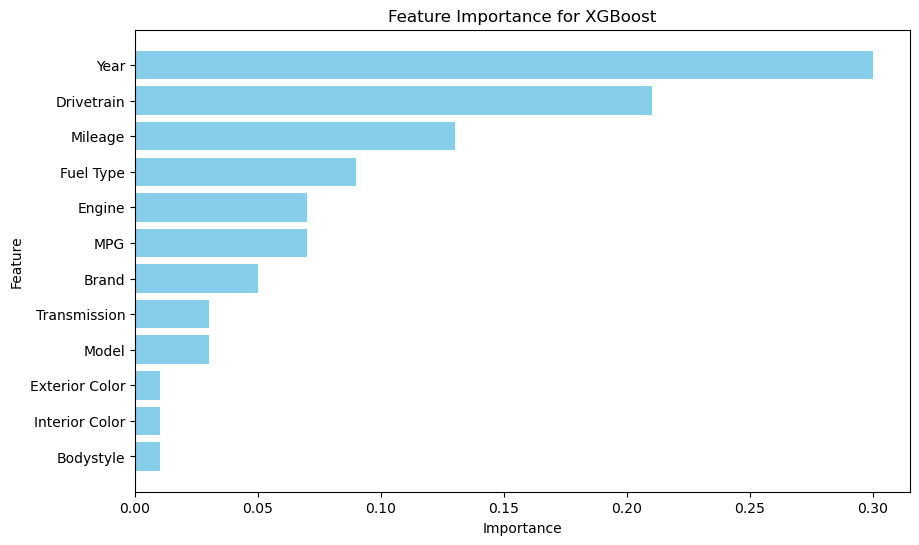

In [50]:
# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for XGBoost')
plt.gca().invert_yaxis()  # Invert y-axis to show most important features on top
plt.show()

#### Comments :

It was observed that Year contributed the most to the model predictions, followed by Drivetrain and Mileage. Bodystyle, Interior Color and Exterior Color appeared to have the least impact on the predictions.

### 6.3 XGBoost Model with feature selection (0.03 or above)

In [51]:
# Filter features with importance >= 0.03
selected_features = feature_importance_df[feature_importance_df['Importance'] >= 0.03]['Feature'].tolist()

# Create a new dataset with selected features
X_train_selected = X_train_normalized[selected_features]

# Display selected features
print("Selected features with importance >= 0.03:")
selected_features

Selected features with importance >= 0.03:


['Year',
 'Drivetrain',
 'Mileage',
 'Fuel Type',
 'Engine',
 'MPG',
 'Brand',
 'Transmission',
 'Model']

In [52]:
# Fix random seed for reproducibility
np.random.seed(2024)

# Initialize the model with the best hyperparameters
xg_model_best = xgb.XGBRegressor(random_state=2024,learning_rate=0.1, min_child_weight=1, n_estimators=500)

# Convert to NumPy arrays 
X_train_selected_features_array = np.array(X_train_selected)
y_train_selected_features_array = np.array(y_train_normalized)

# Evaluate model performance through cross-validation
rmse_scores = []  
r2_scores = []    
for train_index, val_index in k_fold_10.split(X_train_selected_features_array, y_train_selected_features_array):
    X_train_fold, X_val_fold = X_train_selected_features_array[train_index], X_train_selected_features_array[val_index]
    y_train_fold, y_val_fold = y_train_selected_features_array[train_index], y_train_selected_features_array[val_index]
    
    xg_model_best.fit(X_train_fold, y_train_fold)
    y_pred = xg_model_best.predict(X_val_fold)
    
    # Calculate R-squared
    r2 = r2_score(y_val_fold, y_pred)  
    r2_scores.append(r2)
    
    # Revert the logged price back to its original price
    y_pred = np.expm1(y_pred)
    y_val_fold = np.expm1(y_val_fold)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))  
    rmse_scores.append(rmse)

# Calculate average RMSE and R-squared at training set
xg_r2 = np.mean(r2_scores)
xg_rmse = np.mean(rmse_scores)

print("R-squared: {:.2f}".format(xg_r2))
print("RMSE: {:.2f}".format(xg_rmse))


R-squared: 0.89
RMSE: 5474.32


#### Comments :

Using data consisting only of features excluding Exterior Color, Interior Color, and Bodystyle, XGBoost model was trained, and it showed better performance compared to using all features.

### 6.4 Actual vs Predicted Car Prices

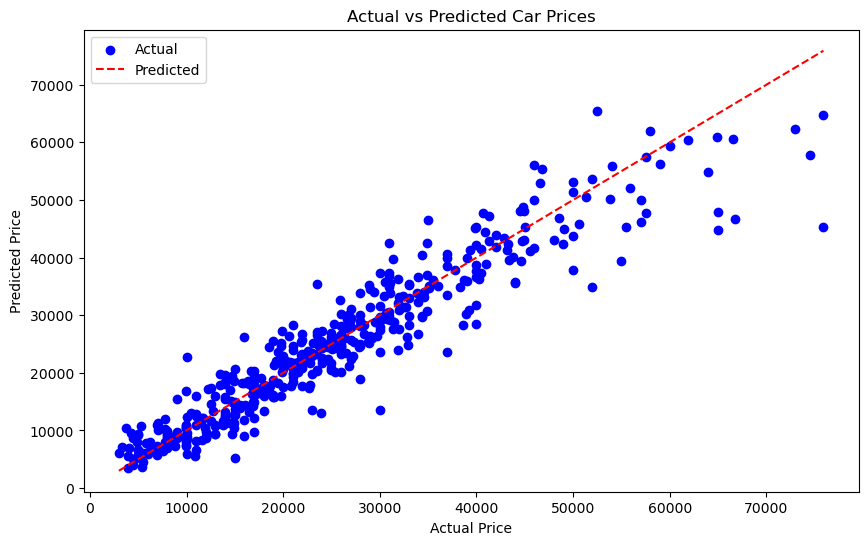

In [53]:
# Import matplotlib library for plotting
import matplotlib.pyplot as plt

# Create a plot comparing actual and predicted car prices
plt.figure(figsize=(10, 6))

# Plot actual car prices
plt.scatter(y_val_fold, y_pred, color='blue', label='Actual')

# Plot predicted car prices
plt.plot([min(y_val_fold), max(y_val_fold)], [min(y_val_fold), max(y_val_fold)], color='red', linestyle='--', label='Predicted')

# Labeling the plot
plt.title('Actual vs Predicted Car Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.legend()

# Show plot
plt.show()


#### Comments :

It was observed that the points clustered around the diagonal line, indicating minimal error between the actual and predicted prices. However, it was noted that for higher prices, the predicted prices tended to be lower than the actual prices, while for cars priced at 40,000 or less, the predictions were more accurate.

### 6.5 Predict Used_Car Values

The XGBoost model was used to predict the market price of the desired vehicle. Inputted the values of the features used to train the XGBoost model ('Year', 'Drivetrain', 'Mileage', 'Fuel Type', 'Engine', 'MPG', 'Brand', 'Transmission', 'Model') and compared the price predicted by the model with the prices of actual vehicles of the same model.

To predict the price of the 2016 Honda Odyssey, the vehicle's information below was inputted into the model to see what price it predicted. 
•	Brand: HONDA | Model: ODYSSEY | Year: 2016 | Mileage: 75,000 | Drivetrain: FRONT-WHEEL
Fuel Type: GASOLINE | Engine: 3.5l_v6_24v | MPG: 19–28 | Transmission: AUTOMATIC

In [61]:
# Define categorical and numerical features
categorical_features= ['Drivetrain', 'Fuel Type', 'Engine', 'MPG', 'Brand', 'Transmission', 'Model']
numerical_features = ['Year', 'Mileage']

# Create empty DataFrames for categorical and numerical targets
categorical_target = pd.DataFrame(columns=[categorical_features])
numerical_target = pd.DataFrame(columns=[numerical_features])

# Add data to categorical_target and numerical_target
categorical_target.loc[0] = [ 'front-wheel', 'gasoline','3.5l_v6_24v', '19–28','honda','automatic','odyssey']
numerical_target.loc[0] = [2016, 75000]


In [62]:
# Create an empty DataFrame with columns based on categorical_features
categorical_target_temp = pd.DataFrame(columns=[categorical_features])

# Extract the relevant data from the 'temp' DataFrame based on categorical_features
temp_data = temp[categorical_features]

# Dictionary to store indices of matching values for each column
column_indices = {}

# Iterate through columns in categorical_target DataFrame
for column in categorical_target.columns:
    
    # Check if the column is present in temp_data columns
    if column[0] in temp_data.columns:
        c = column[0]
        column_indices[c] = []
        for value in categorical_target[c].values[0]:
            if len(column_indices[c]) == 0:
                indices = temp_data[c].apply(lambda x: x == value or x.startswith(value))
                column_indices[c].append(temp_data.index[indices].tolist())
        
value_list=[]

# Iterate through the dictionary to find the first matching index for each column
for key, value in column_indices.items():
    if value:
        
        # Get the index value from the first element of the first list in value
        index_value = temp_data.index[value[0][0]]
        value_list.append(index_value)

# Assign the list of index values to the first row of categorical_target_temp DataFrame
categorical_target_temp.loc[0] = value_list

In [63]:
# Transforming numerical target variable using logarithm transformation
numerical_target_temp = np.log1p(numerical_target)

# Combining transformed numerical and categorical features
X_train_temp = numerical_target_temp.join(categorical_target_temp)

# Reordering columns for X_train_temp
column_order = ['Year', 'Drivetrain', 'Mileage', 'Fuel Type', 'Engine', 'MPG', 'Brand', 'Transmission', 'Model']
X_train_temp = X_train_temp[column_order]

In [64]:
# Generate predictions using the best XGBoost model on the training data
y_pred = xg_model_best.predict(X_train_temp)

# Transform the predicted prices back to their original scale
price = np.expm1(y_pred)

# Print the details of the car and its estimated price
print(f"Brand : ", categorical_target['Brand'].values[0][0])
print(f"Model : ", categorical_target['Model'].values[0][0])
print(f"Year  : ", numerical_target['Year'].values[0][0])
print(f"Mileage ", numerical_target['Mileage'].values[0][0])
print(f"Estimated Price :", price[0])

Brand :  honda
Model :  odyssey
Year  :  2016
Mileage  75000
Estimated Price : 18738.725


### Compare same model

In [65]:
categorical_target['Model'].values[0][0]

'odyssey'

In [66]:
# Extracting relevant columns from the dataframe
actual_car_info = temp[["Brand","Model","Year","Mileage","Drivetrain","Fuel Type","Engine","MPG","Transmission","Price"]]

# Fetching the model of interest from the categorical_target dataframe
model = categorical_target['Model'].values[0][0]

# Filtering actual_car_info dataframe to include only rows with the same model as the fetched model
same_model = actual_car_info[actual_car_info["Model"] == model]
same_model

,Brand,Model,Year,Mileage,Drivetrain,Fuel Type,Engine,MPG,Transmission,Price
552,honda,odyssey,2019,25891,front-wheel,gasoline,regular_unleaded_v-6,19–28,automatic,28991
1672,honda,odyssey,2019,50425,front-wheel,gasoline,3.5l_v6_280hp,19–28,9-speed_shiftable,26995
1968,honda,odyssey,2023,1408,front-wheel,gasoline,3.5l_v6_24v,19–28,10-speed_automatic,46998
2856,honda,odyssey,2018,66368,front-wheel,gasoline,3.5l_v6_24v,19–28,9-speed_automatic,23931


#### Comments :

The model's predicted price was $ 18,738 and compared to the four identical car models used in the data. This predicted price seems relatively reasonably accurate. The model was able to predict a lower price of 18,738 compared to the price of 23,931 for the 2018 Honda Odyssey, considering it was older and had approximately 9,000 more miles driven

## 7. Build Model for web application with 4 features

In [67]:
# Fix random seed for reproducibility
np.random.seed(2024)

# Selected features for Web application
selected_features_web = ['Year', 'Mileage', 'Brand', 'Model']

# Create a new dataset with selected features
X_train_selected_web = X_train_normalized[selected_features_web]

# Initialize the model with the best hyperparameters
xg_model_web = xgb.XGBRegressor(random_state=2024,learning_rate=0.1, min_child_weight=1, n_estimators=500)

# Convert to NumPy arrays 
X_train_selected_web_array = np.array(X_train_selected_web)
y_train_selected_web_array = np.array(y_train_normalized)

# Evaluate model performance through cross-validation
rmse_scores = []  
r2_scores = []    
for train_index, val_index in k_fold_10.split(X_train_selected_web_array, y_train_selected_web_array):
    X_train_fold, X_val_fold = X_train_selected_web_array[train_index], X_train_selected_web_array[val_index]
    y_train_fold, y_val_fold = y_train_selected_web_array[train_index], y_train_selected_web_array[val_index]
    
    xg_model_web.fit(X_train_fold, y_train_fold)
    y_pred = xg_model_web.predict(X_val_fold)
    
    # Calculate R-squared
    r2 = r2_score(y_val_fold, y_pred)  
    r2_scores.append(r2)
    
    # Revert the logged price back to its original price
    y_pred = np.expm1(y_pred)
    y_val_fold = np.expm1(y_val_fold)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))  
    rmse_scores.append(rmse)

# Calculate average RMSE and R-squared at training set
xg_r2 = np.mean(r2_scores)
xg_rmse = np.mean(rmse_scores)

print("R-squared: {:.2f}".format(xg_r2))
print("RMSE: {:.2f}".format(xg_rmse))

R-squared: 0.87
RMSE: 6107.43


#### Comments :

By using only four features, the model's performance showed a 2% decrease in R-squared and an increase in RMSE by 633.11, yet it still exhibited better performance compared to the other four models. Therefore, for the web application, the model utilized would be trained on XGBoost with only four features. This allowed users to comfortably use the web application by inputting only four values like Brand, Model, Year, Mileage